# 4.0.1-Level 1 annotation

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-20"

## Introduction

Integrate CD3+ cells from CD45+ and CD3+ enrich compartment from T0 (Tumour) to do level 1 annotation of main cell types

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(harmony)
library(dittoSeq)
library(pheatmap)
}))

## Parameters

In [3]:
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))
source(here("utils/style.R"))

set.seed(0)

## Load data

In [4]:
cd45_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.0-l1_T0_CD45pos.rds")))
cd3_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.0-l1_T0_CD3pos.rds")))

In [5]:
list_objects = list()
list_objects$T0_CD3pos <- cd3_obj
list_objects$T0_CD45pos <- cd45_obj

Get HVG

In [6]:
hvg <- c(VariableFeatures(list_objects$T0_CD3pos), VariableFeatures(list_objects$T0_CD45pos))

In [7]:
list_objects <- lapply(names(list_objects), function(frc) {
    obj <- list_objects[[frc]]
    obj@meta.data$sample_id <- frc
    
    df_meta <- obj@meta.data
    seurat.matrix <- obj@assays[["RNA"]]@counts 

    colnames(seurat.matrix) <- paste(frc,colnames(seurat.matrix), sep='_')
    rownames(df_meta) <- paste(frc,rownames(df_meta), sep='_')

    obj_new <- CreateSeuratObject(seurat.matrix, meta.data=df_meta)
    obj_new
})

Merge fractions seurat object

In [8]:
seurat_obj <- merge(
  x = list_objects[[1]],
  y = list_objects[[2]])

In [9]:
seurat_obj <- DietSeurat(
  seurat_obj,
  counts = TRUE,
  data = TRUE,
  scale.data = FALSE,
  features = NULL,
  assays = NULL,
  dimreducs = FALSE,
  graphs = NULL
)

In [10]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]


FALSE 
29019 


In [11]:
VariableFeatures(seurat_obj) <- unique(hvg)

In [12]:
# save memory
remove(list_objects)
remove(cd45_obj)
remove(cd3_obj)

## Normalization and Embedding

In [13]:
seurat_obj <- NormalizeData(
seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)
seurat_obj <- seurat_obj %>%
  ScaleData(features=unique(hvg)) %>% 
  RunPCA(features=unique(hvg))

Centering and scaling data matrix

PC_ 1 
Positive:  VCAN, LYZ, S100A9, FCN1, IFI30, PLXDC2, S100A8, SLC11A1, SERPINA1, ACSL1 
	   RNF144B, GLUL, KYNU, FCGR2A, AIF1, LILRB2, CD14, TLR2, CD163, MNDA 
	   SLC8A1, RAB31, CSF3R, LRMDA, ZEB2, THBS1, PLAUR, TYROBP, CPVL, FPR1 
Negative:  IL32, CST7, CD3E, CCL5, IFITM1, GZMA, CD3D, GZMK, NKG7, CTSW 
	   RGS1, CD69, PRF1, B2M, CCL4, LINC01934, HLA-B, GZMB, IKZF2, CTLA4 
	   CCL4L2, TNFRSF9, LTB, GZMH, VCAM1, IFNG, CCL3, ICOS, BATF, AL133405.2 
PC_ 2 
Positive:  MS4A1, FCRL1, BANK1, LINC00926, AFF3, TCL1A, NIBAN3, EBF1, CD79A, FCRL5 
	   BLK, IGHM, VPREB3, BACH2, IGHD, JCHAIN, PCDH9, IGKC, AL589693.1, CCR7 
	   IGLC2, IGLC1, RHEX, SELL, IGHG1, IGHV3-23, SOX5, IGHG3, CCSER1, IGLC3 
Negative:  SRGN, NKG7, CCL5, CST7, GZMK, GZMA, CTSW, PRF1, HLA-B, B2M 
	   FCGR3A, MT2A, CCL4, GZMB, CD3E, CCL4L2, CD3D, GZMH, CCL3, S100A4 
	   VCAM1, IL32, IFITM1, S100A11, AOAH, RGS1, TNFRSF9, IFNG, S100A6, RGS2 
PC_ 3 
Positive:  KIT, IL1RL1, SLC24A3, HDC, CPA3, T

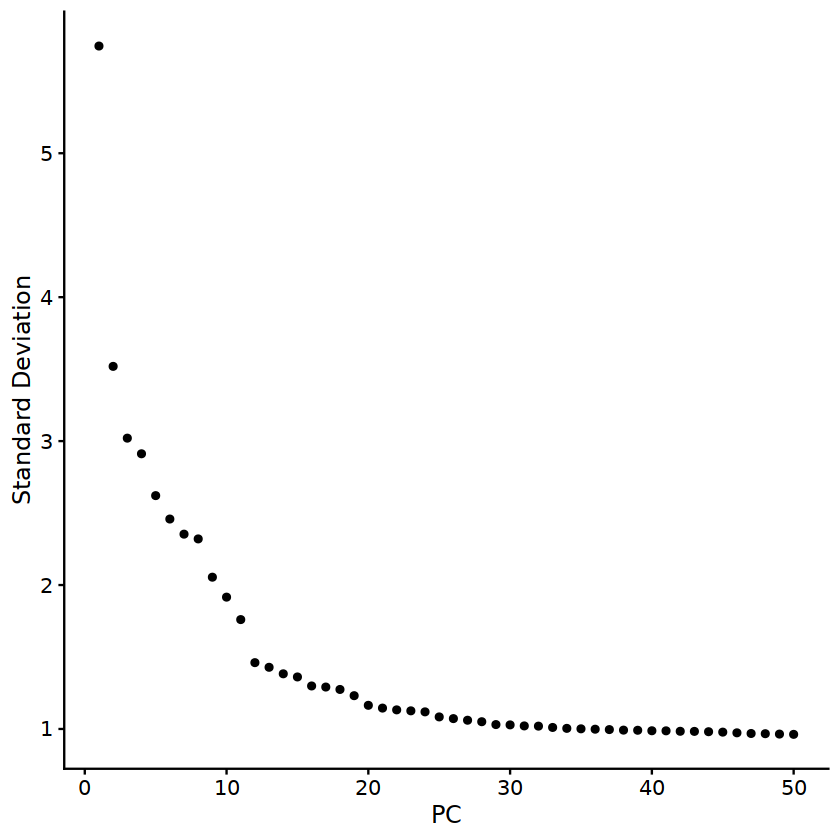

In [14]:
ElbowPlot(seurat_obj, n=50)

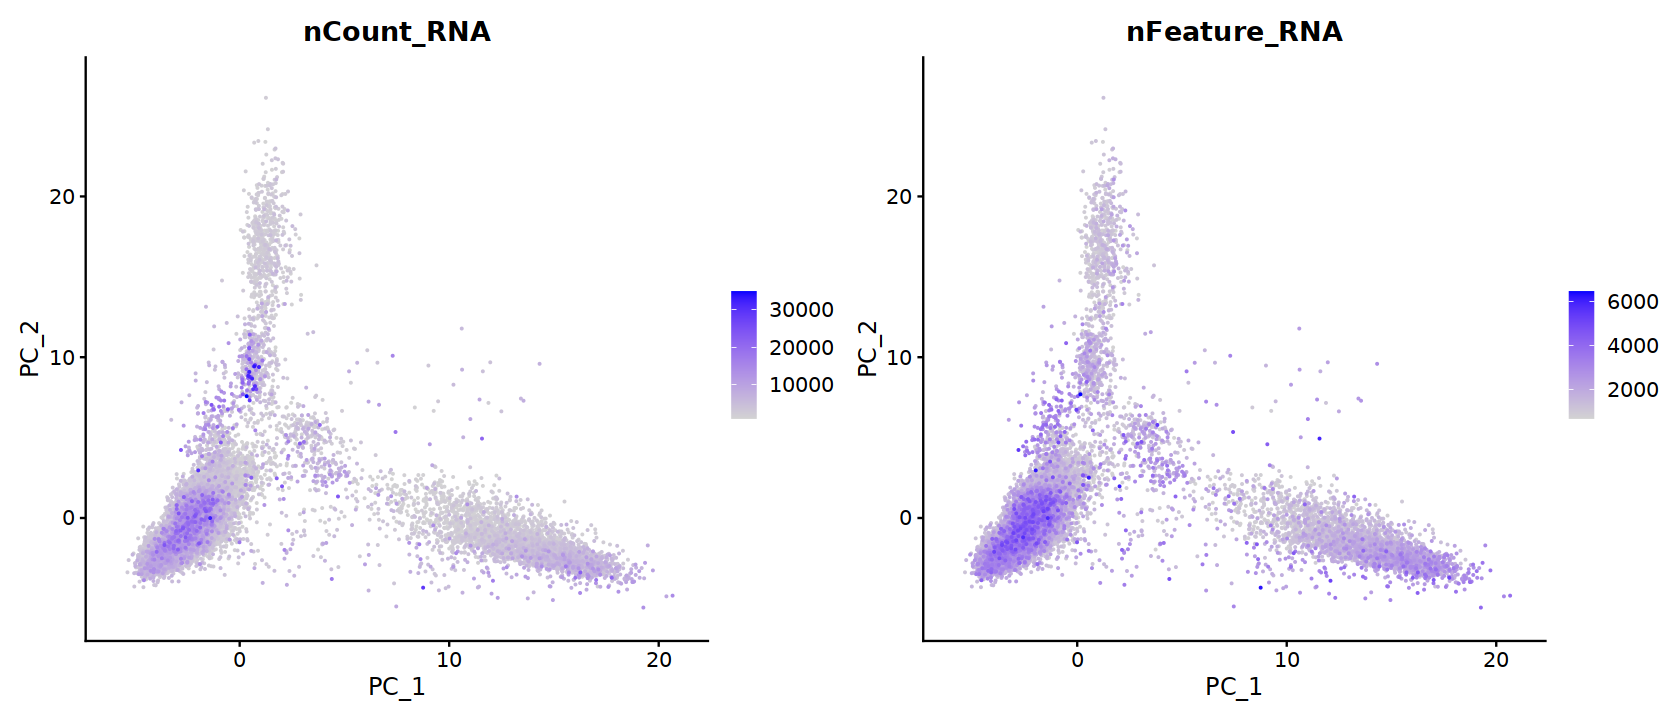

In [15]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
    features = c("nCount_RNA", "nFeature_RNA"), order = T)

In [16]:
comp = 25

In [17]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

15:57:44 UMAP embedding parameters a = 0.9922 b = 1.112

15:57:44 Read 22617 rows and found 25 numeric columns

15:57:44 Using Annoy for neighbor search, n_neighbors = 30

15:57:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:57:46 Writing NN index file to temp file /scratch_tmp/34289041/RtmpsTNwTa/file108d21ecbea5b

15:57:46 Searching Annoy index using 1 thread, search_k = 3000

15:57:54 Annoy recall = 100%

15:57:55 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:57:57 Initializing from normalized Laplacian + noise (using irlba)

15:57:57 Commencing optimization for 200 epochs, with 1013638 positive edges

15:58:23 Optimization finished



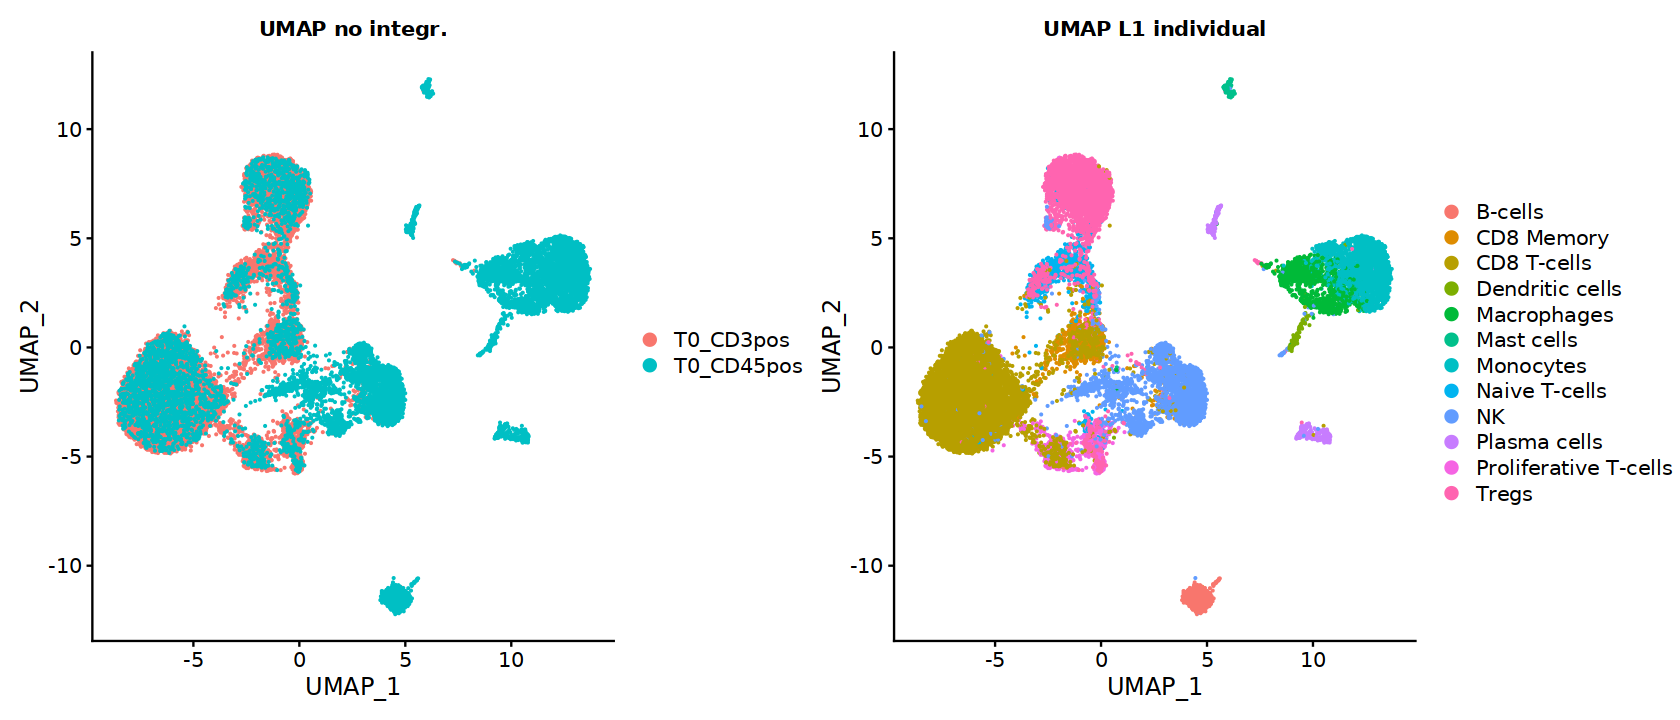

In [18]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
dp1 <- DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP no integr.') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp2 <- DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "l1_annot",
  pt.size = 0.1
) + ggtitle('UMAP L1 individual') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dp1 + dp2

### Integration with Harmony

In [19]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

In [20]:
seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



In [21]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

15:58:40 UMAP embedding parameters a = 0.9922 b = 1.112

15:58:40 Read 22617 rows and found 25 numeric columns

15:58:40 Using Annoy for neighbor search, n_neighbors = 30

15:58:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:58:42 Writing NN index file to temp file /scratch_tmp/34289041/RtmpsTNwTa/file108d26bafaa19

15:58:42 Searching Annoy index using 1 thread, search_k = 3000

15:58:50 Annoy recall = 100%

15:58:50 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:58:52 Initializing from normalized Laplacian + noise (using irlba)

15:58:52 Commencing optimization for 200 epochs, with 1009058 positive edges

15:59:18 Optimization finished



In [22]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
dpt <- DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('Integration\nof fractions') + 
     theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

In [23]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
fp_cd3 <- FeaturePlot(seurat_obj, features="CD3D", order=F) +
    scale_color_viridis_c(option = "magma") + 
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


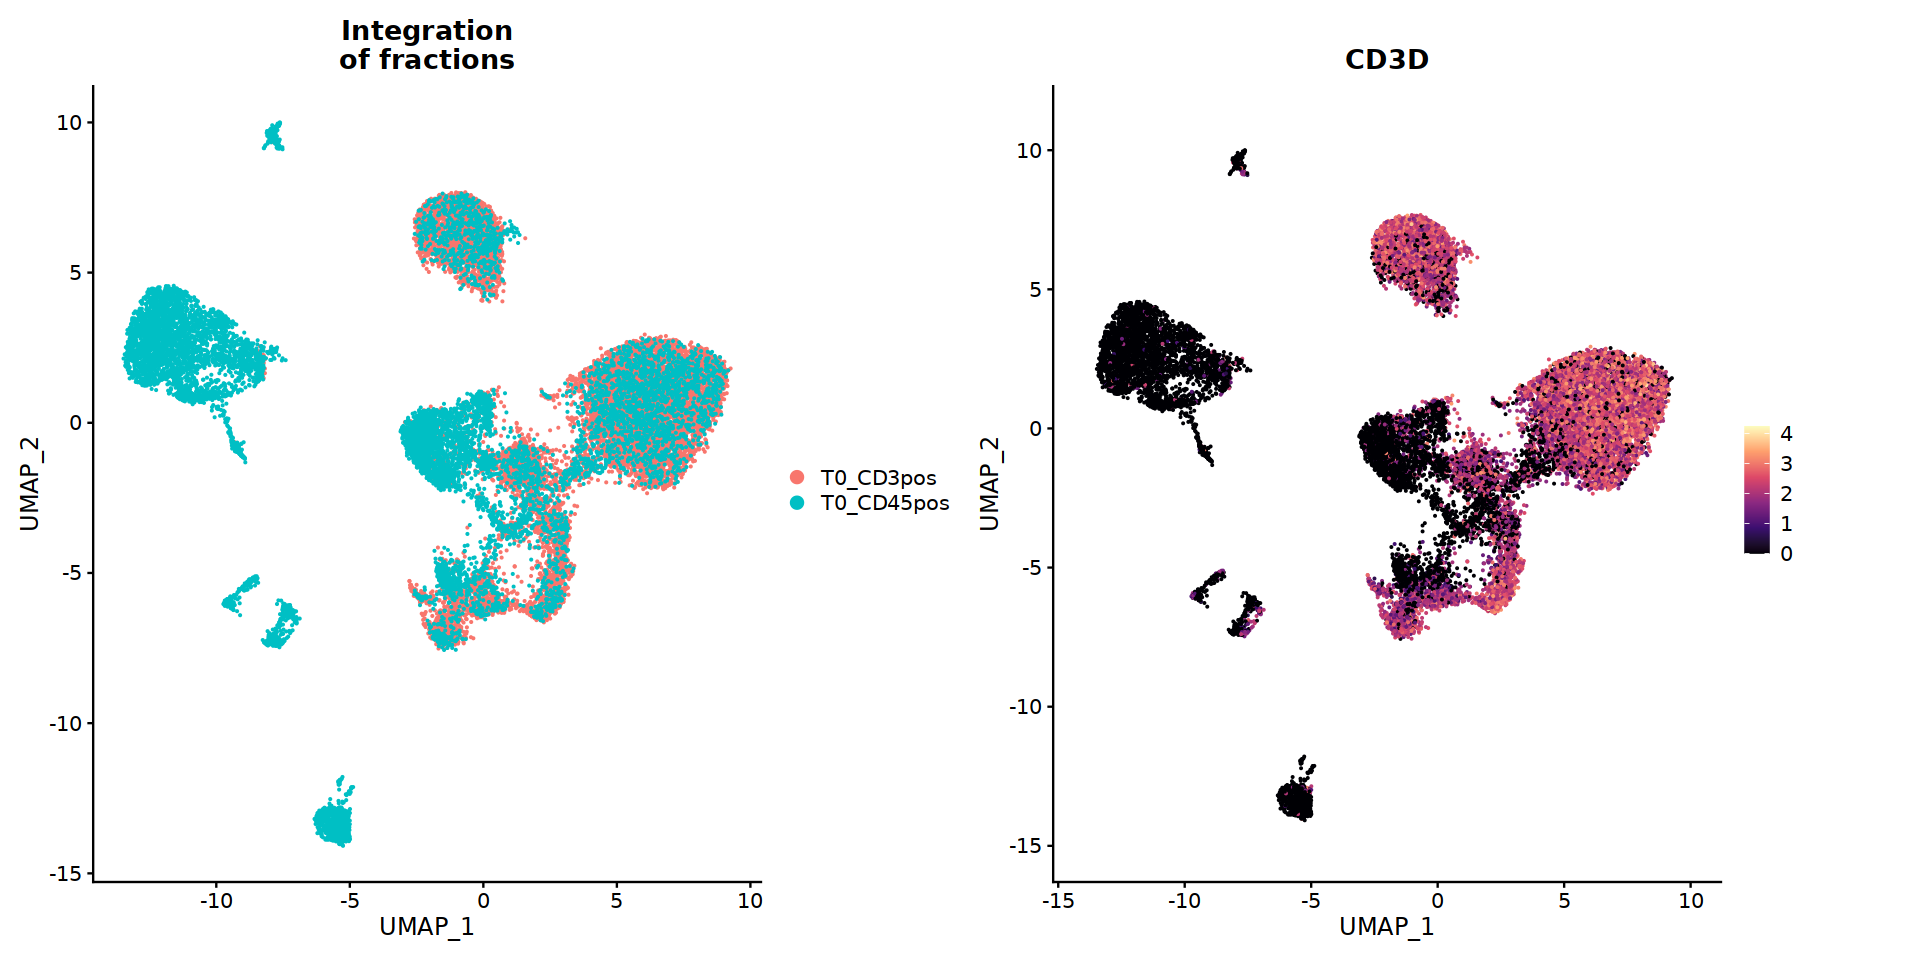

In [24]:
options(repr.plot.width = 16, repr.plot.height = 8, warn=-1,verbose = FALSE)
cd3_pl <- cowplot::plot_grid(plotlist = list(dpt,fp_cd3),
                   align = "hv",
                   axis = "trbl",
                   ncol=2,
                   nrow=1)
cd3_pl

## Clustering

In [25]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "harmony", dims = 1:comp)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.05
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22617
Number of edges: 805199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9667
Number of communities: 9
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22617
Number of edges: 805199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9577
Number of communities: 11
Elapsed time: 4 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22617
Number of edges: 805199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9493
Number of communities: 12
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22617
Number of edges: 805199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9416
Number of communities: 12
Elapsed time: 5 seconds
Modularity Op

In [26]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

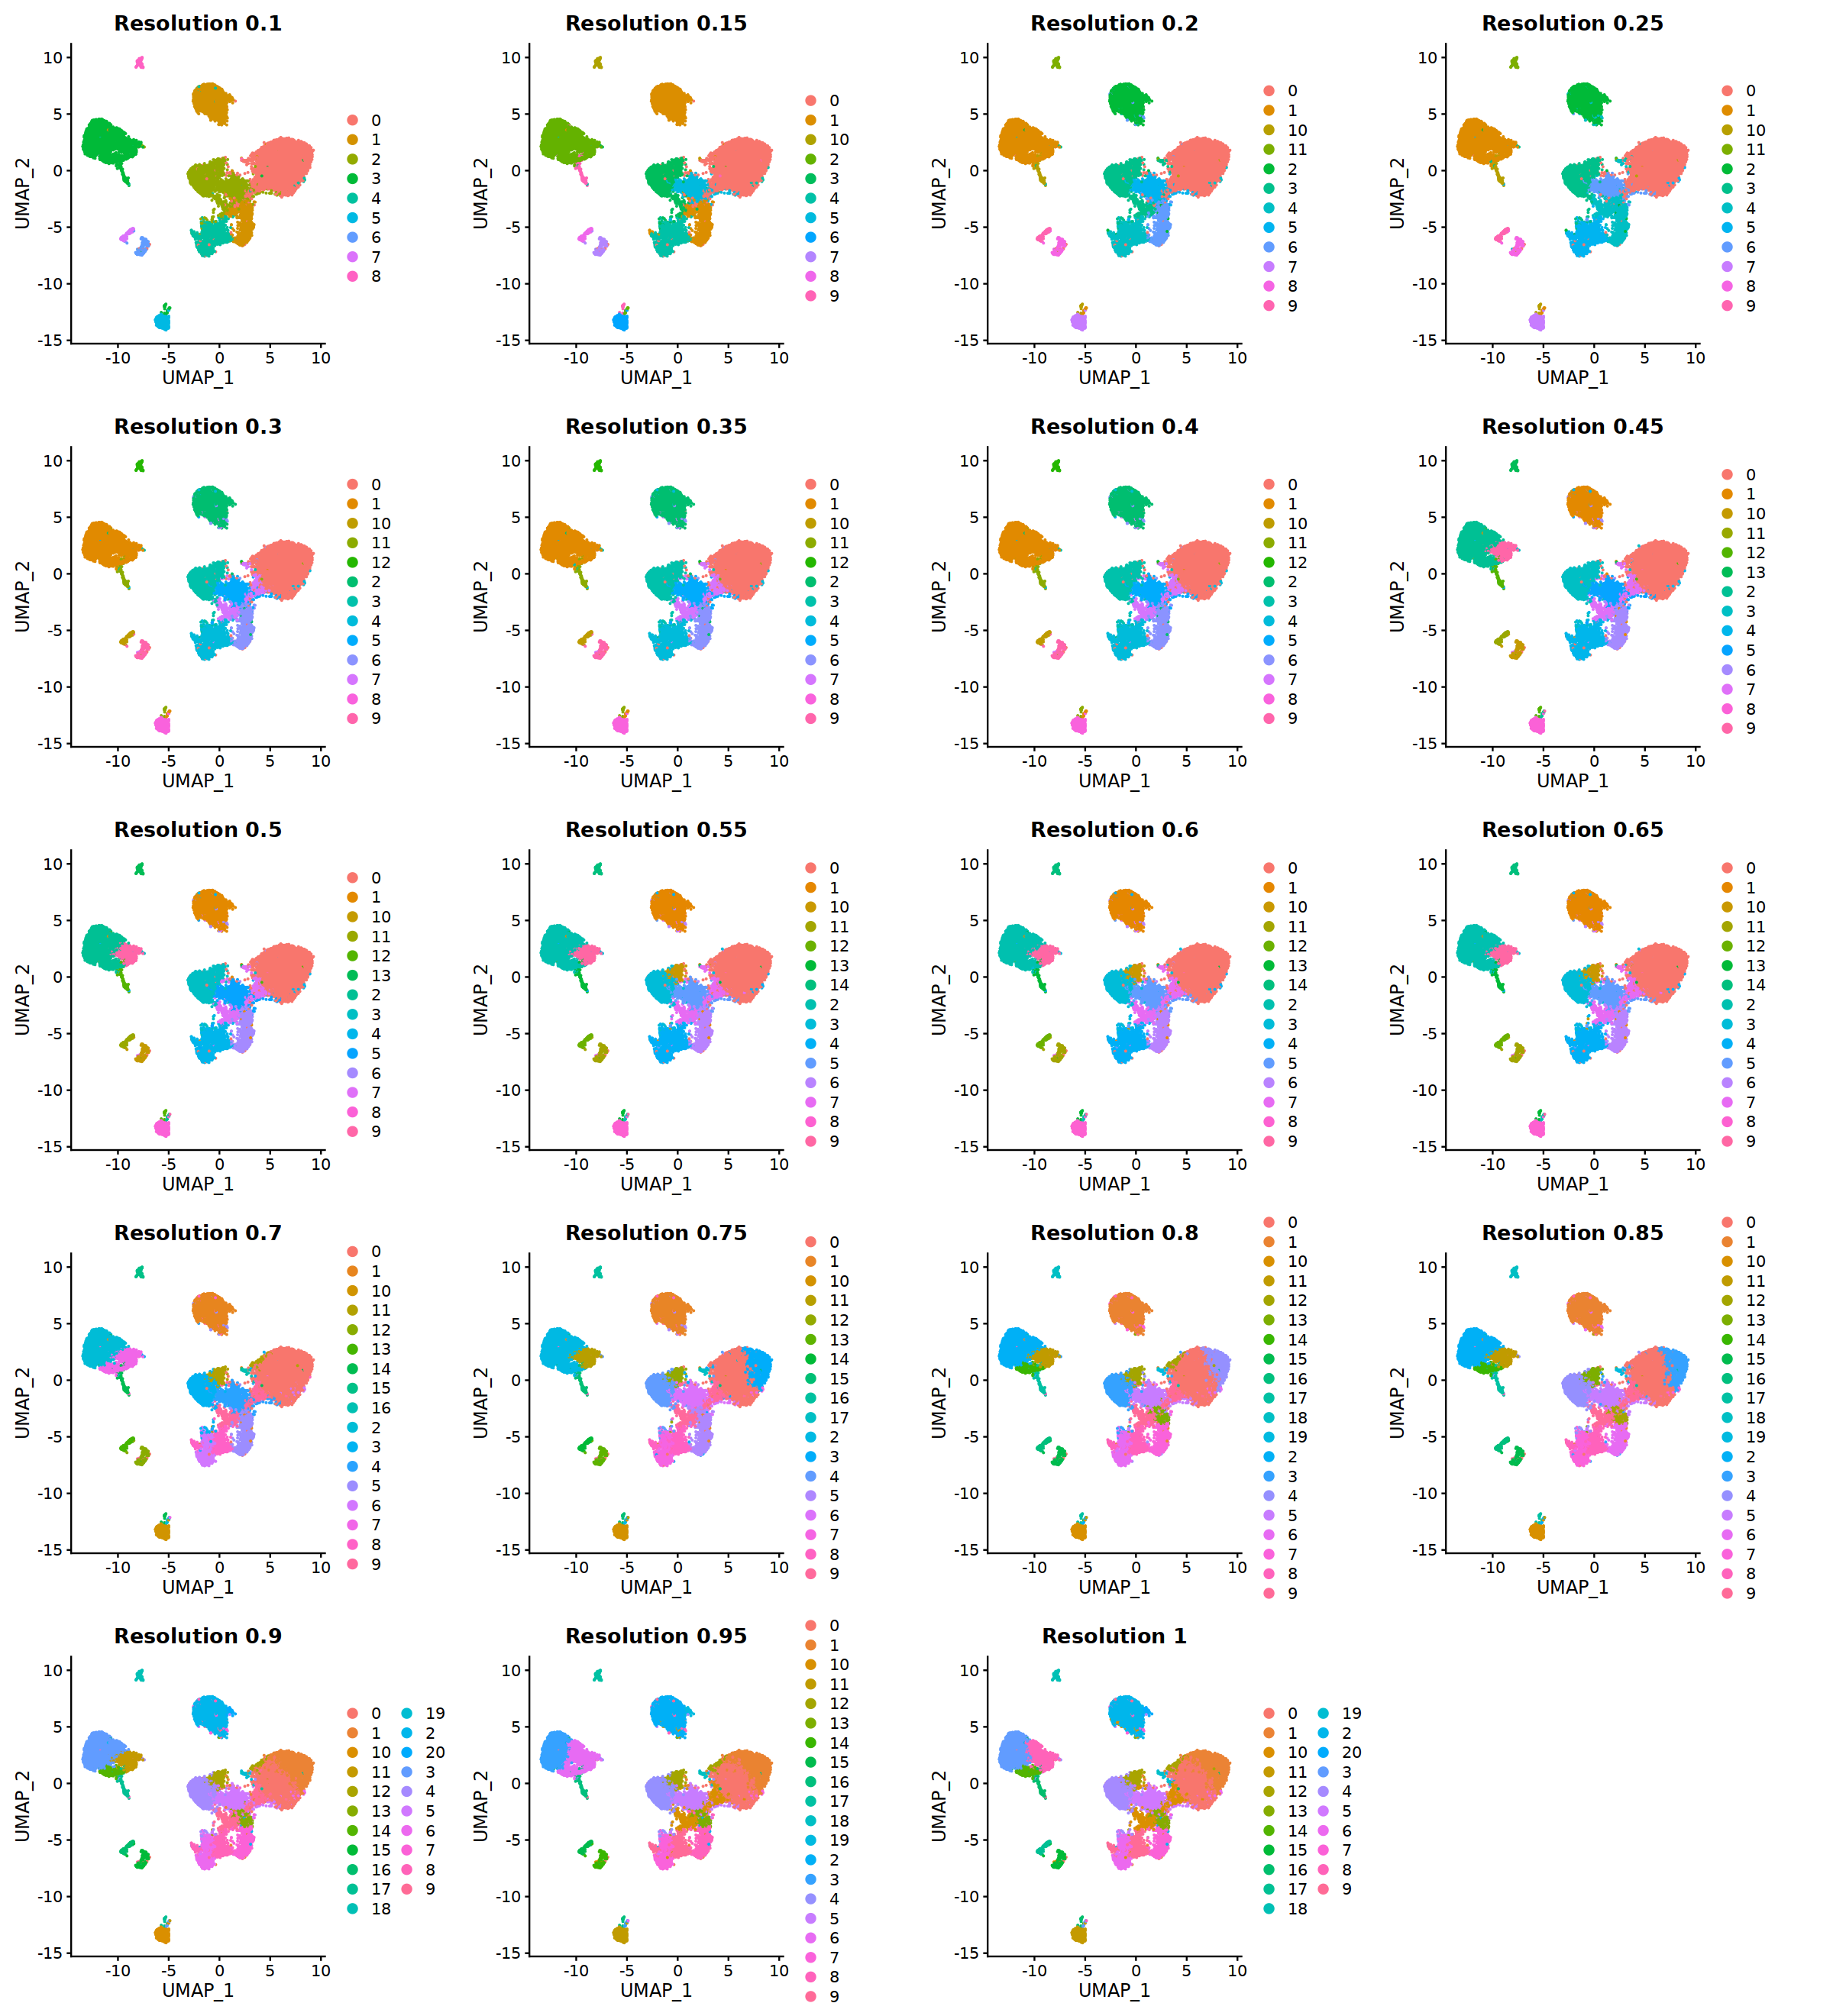

In [27]:
options(repr.plot.width = 20, repr.plot.height = 22, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=5)
cp

In [28]:
reso=0.2

In [29]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22617
Number of edges: 805199

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9493
Number of communities: 12
Elapsed time: 5 seconds


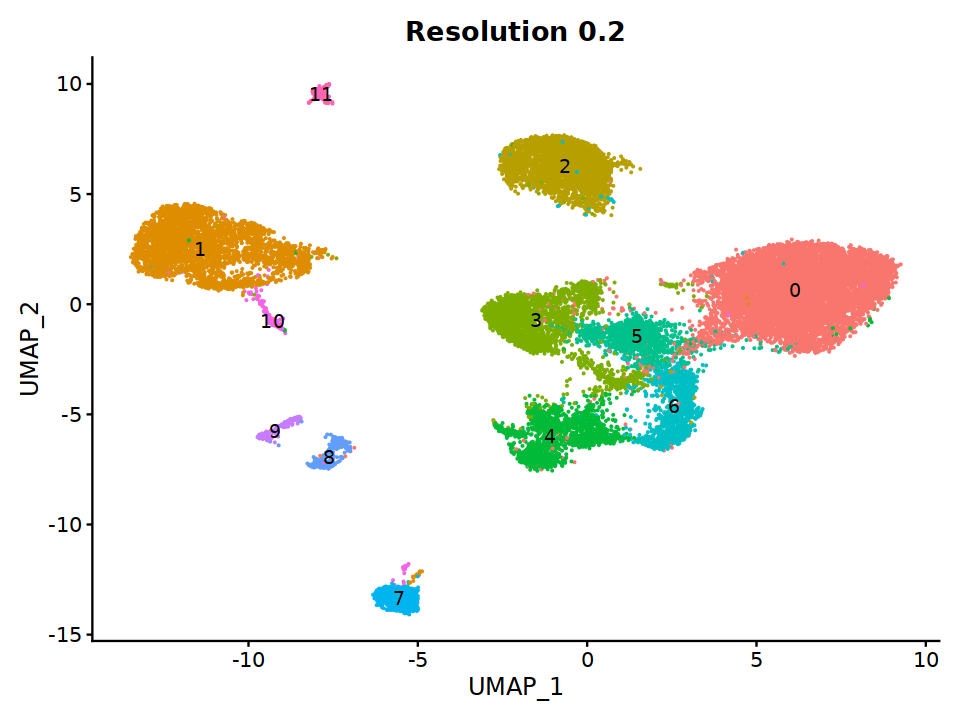

In [30]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Check general cell types

Plot specific markers to annotate main cell types

#### T-cells

In [31]:
markers = c("CD3E", "CD3G","CD4","CD8A", "CD8B","SELL", "LEF1","GZMK","KLRB1",
            "FOXP3", "CXCR3", "GATA3","IL17F", "TRDV1", "TRGV2", "TRGC2")

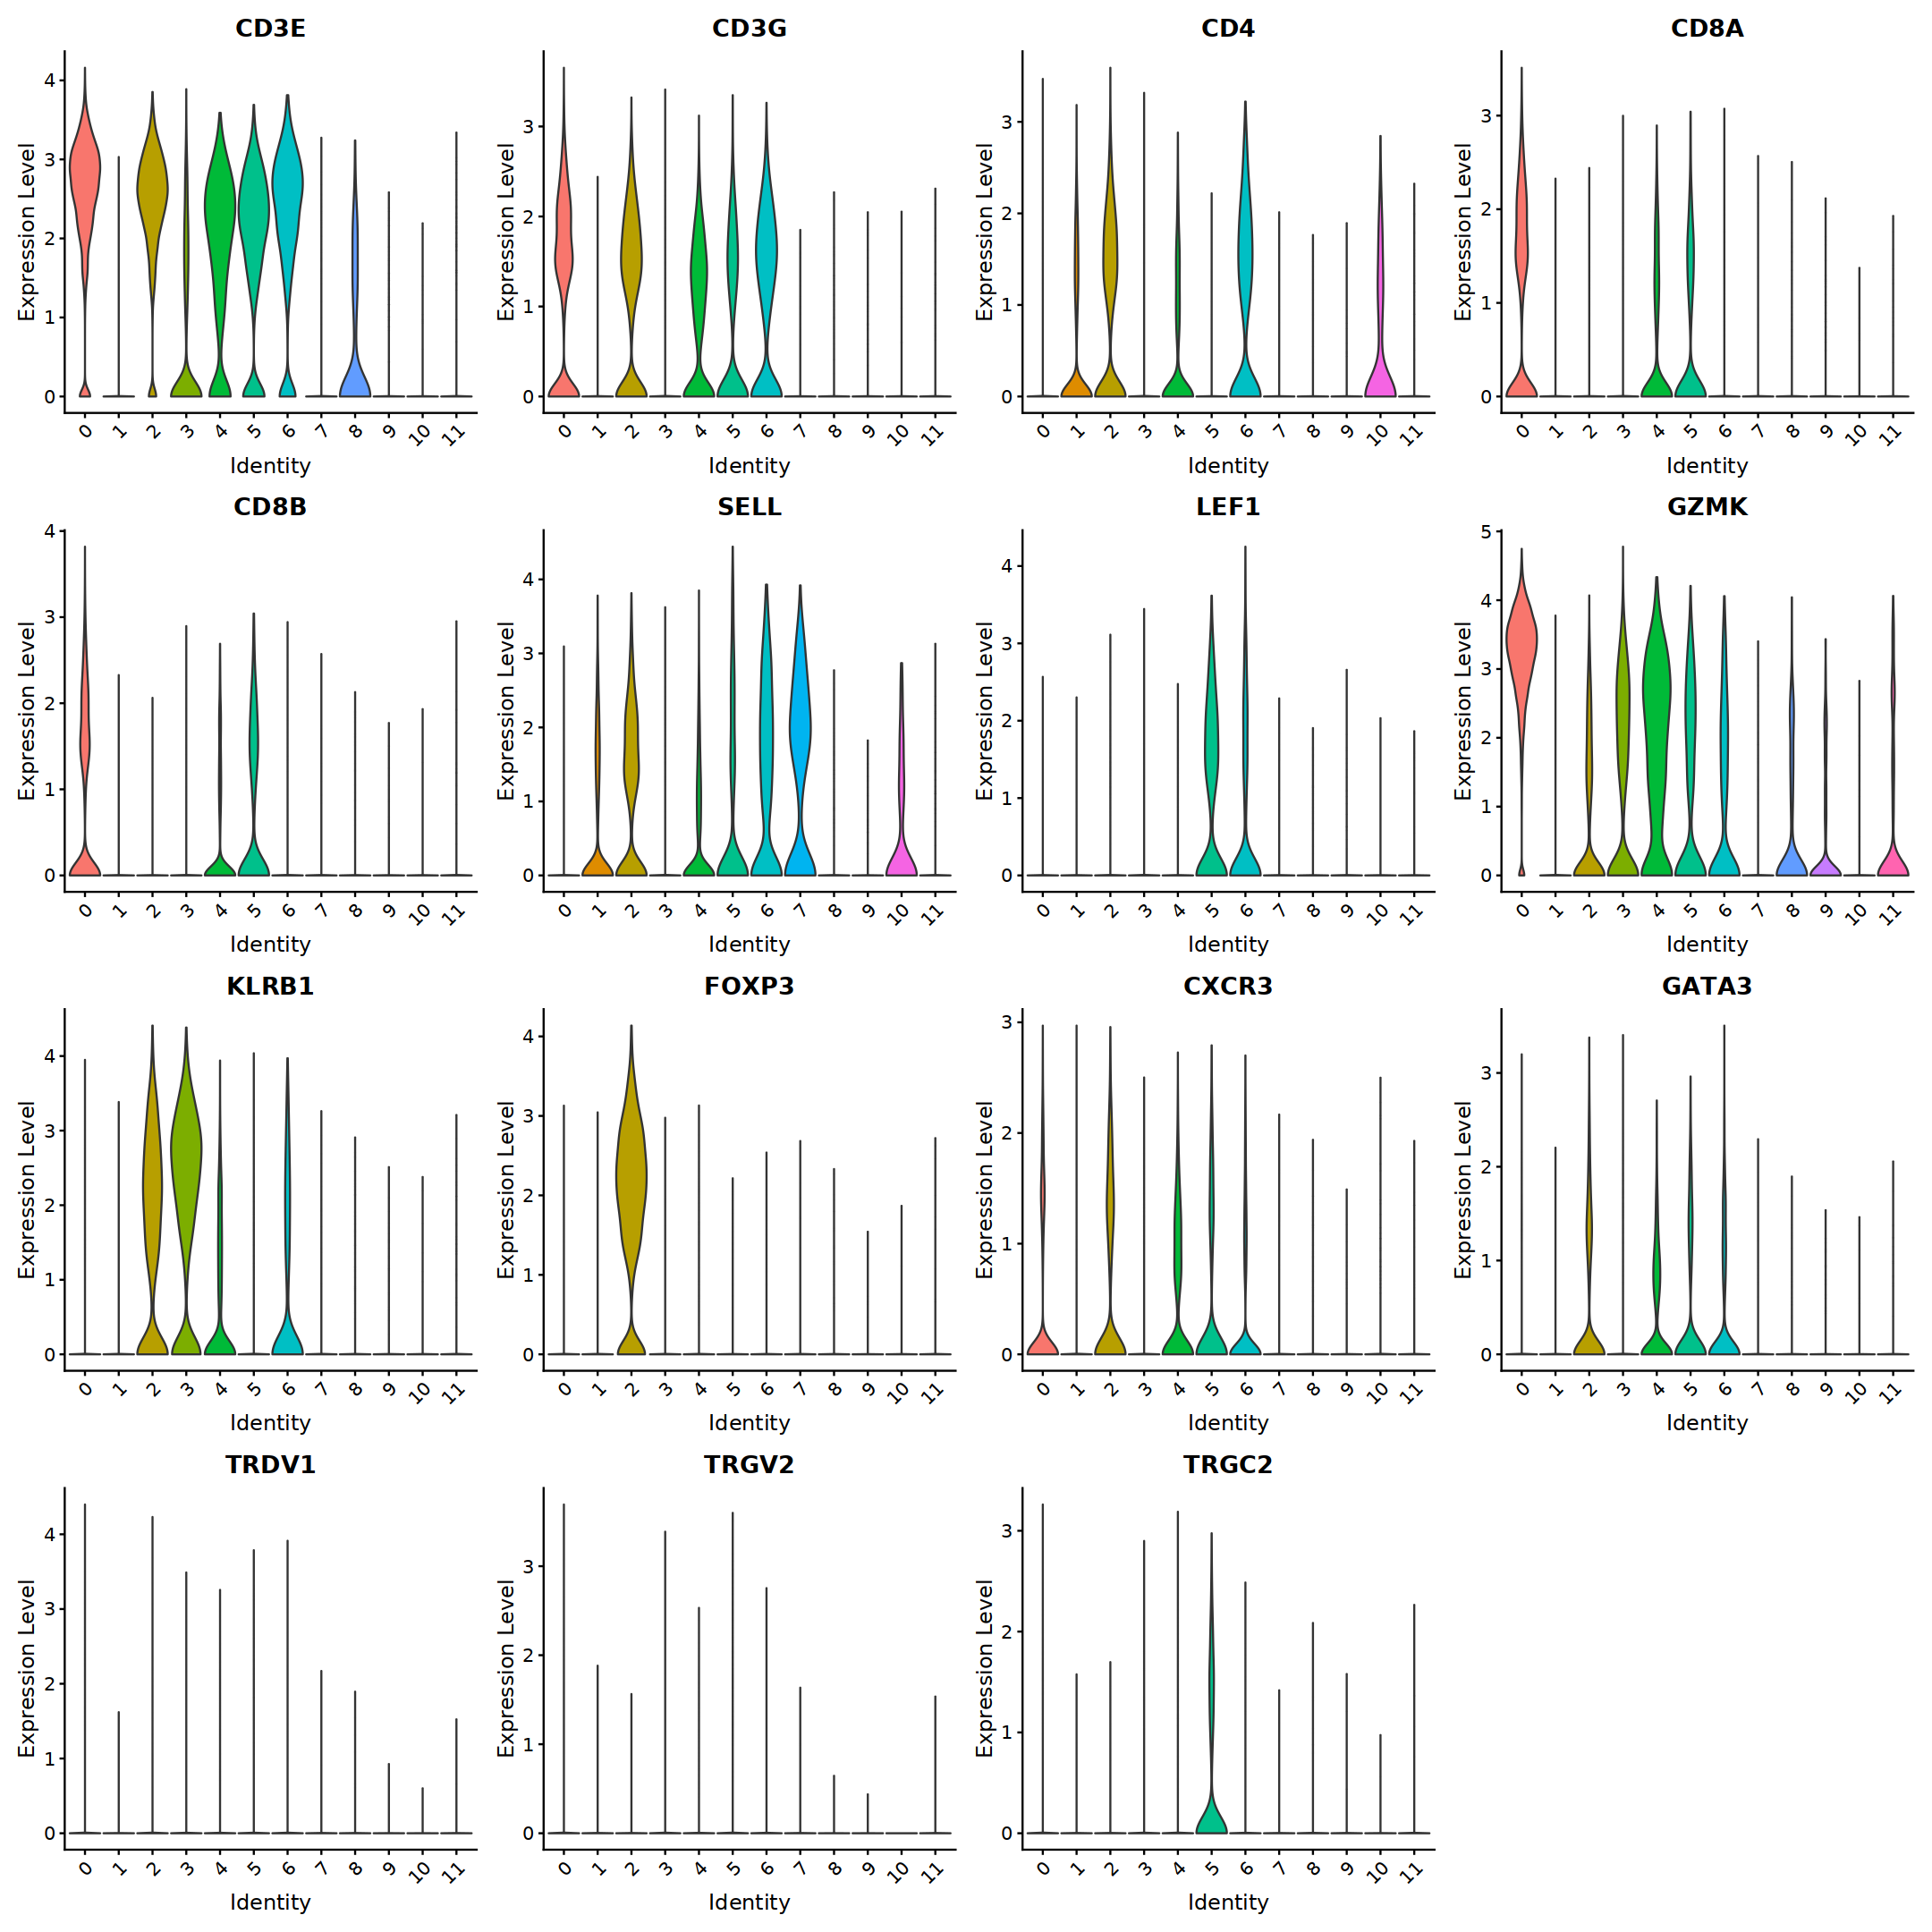

In [32]:
options(repr.plot.width = 18, repr.plot.height = 18, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers,ncol=4, pt.size = 0)

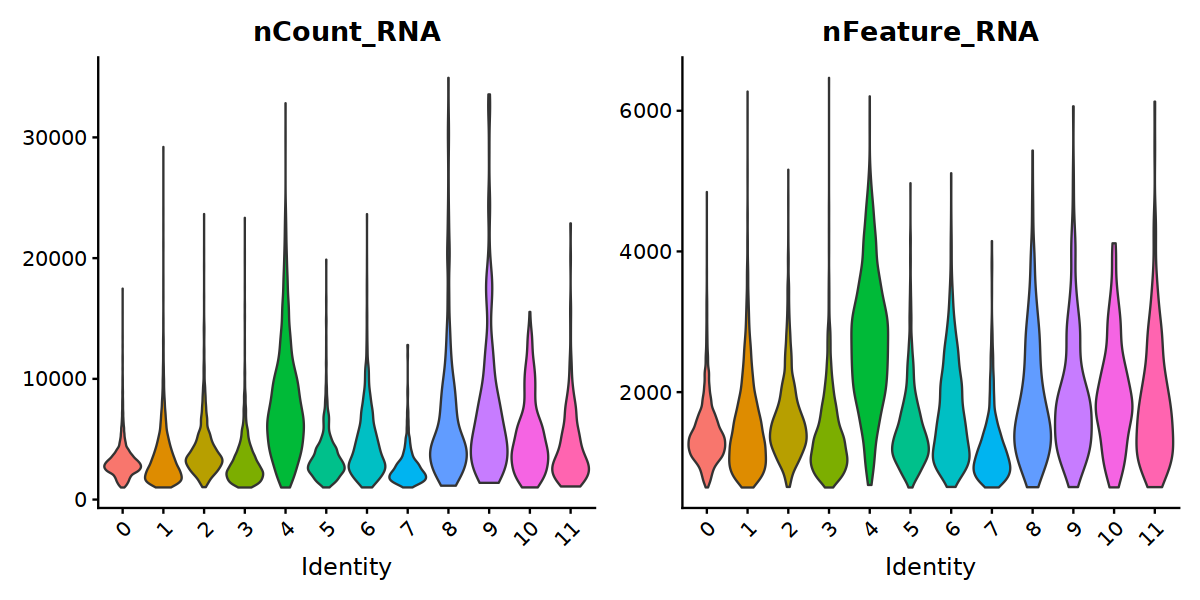

In [33]:
options(repr.plot.width = 10, repr.plot.height = 5, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=c("nCount_RNA", "nFeature_RNA"), pt.size = 0)

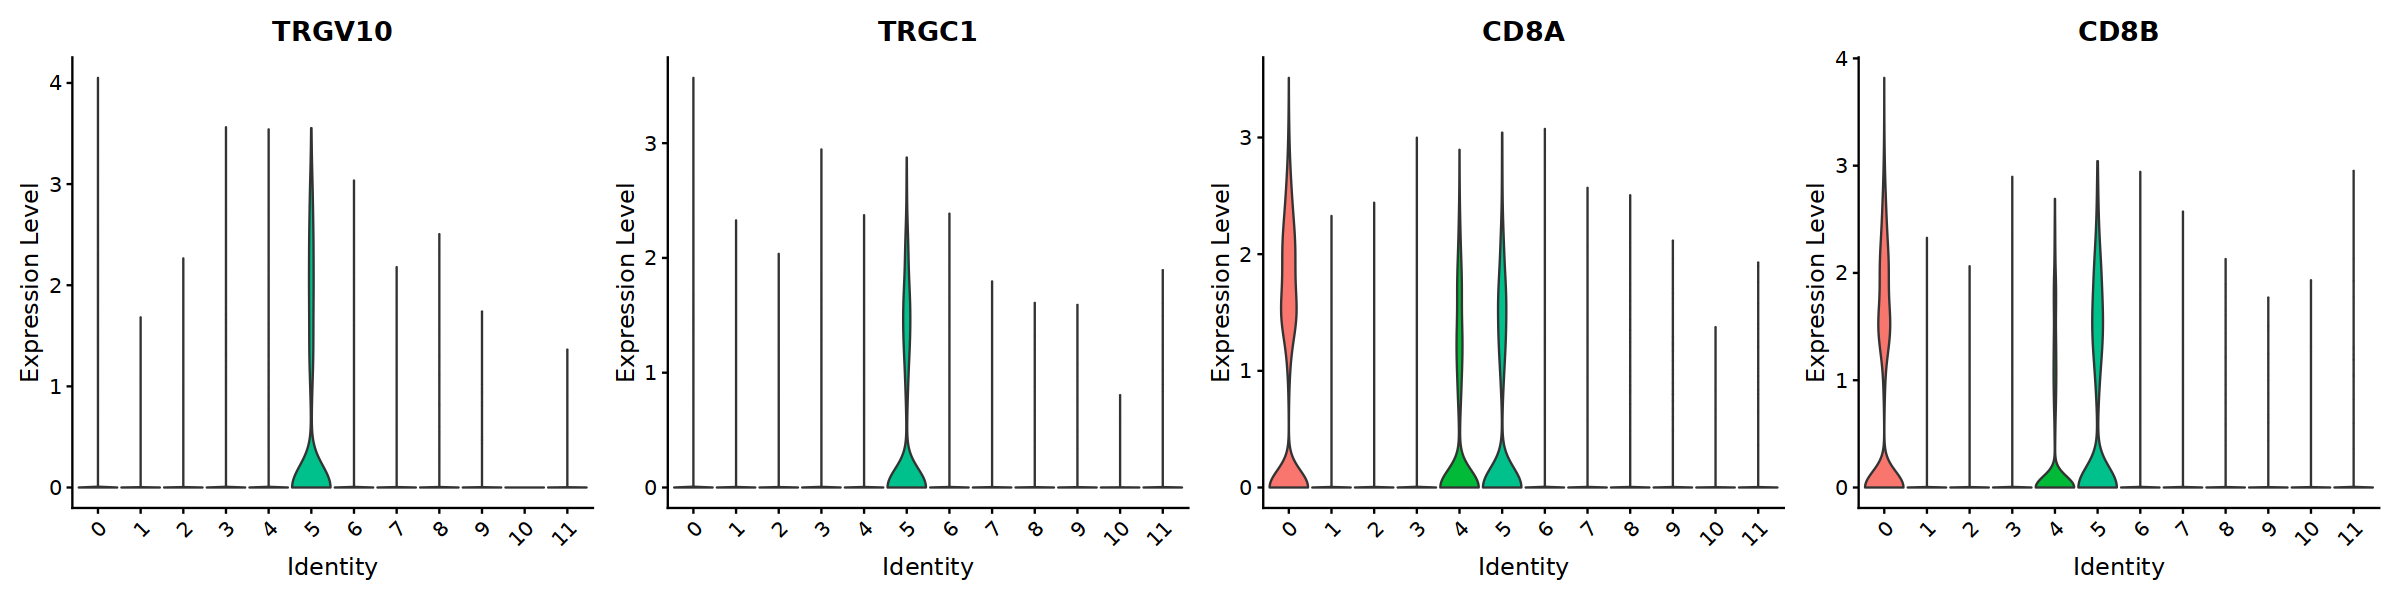

In [34]:
options(repr.plot.width = 20, repr.plot.height = 5, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=c("TRGV10", "TRGC1", "CD8A", "CD8B"), 
        pt.size = 0, ncol = 4)

In [35]:
seurat_obj <- FindSubCluster(
  seurat_obj,
  5,
  graph.name = "RNA_snn",
  subcluster.name = "subclustering",
  resolution = 0.15,
  algorithm = 1
)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1347
Number of edges: 48057

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8519
Number of communities: 2
Elapsed time: 0 seconds


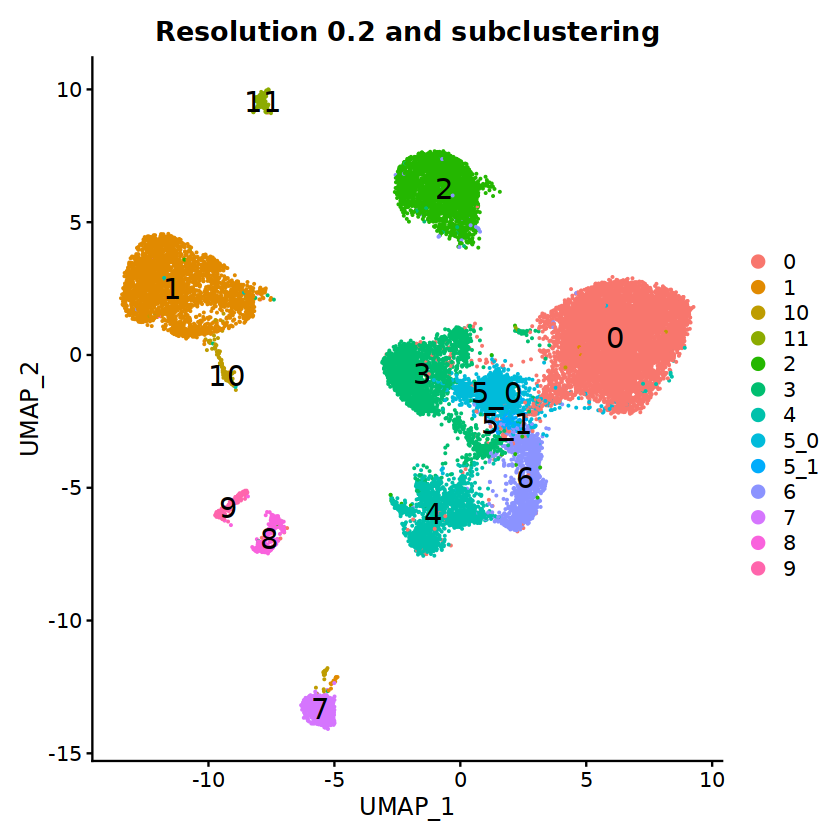

In [36]:
options(repr.plot.width = 7, repr.plot.height = 7, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, group.by = "subclustering", label = TRUE, label.size = 6) + 
ggtitle(glue('Resolution 0.2 and subclustering')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

In [37]:
seurat_obj <- SetIdent(seurat_obj, value=seurat_obj@meta.data$subclustering)

#### Natural Killers

In [38]:
markers = c("NCAM1", "FCGR3A", "CX3CR1", "GNLY", "KLRC2", "KLRD1", 
            "KLRC3", "KLRK1", "KLRC1", "GNLY", "NKG7")

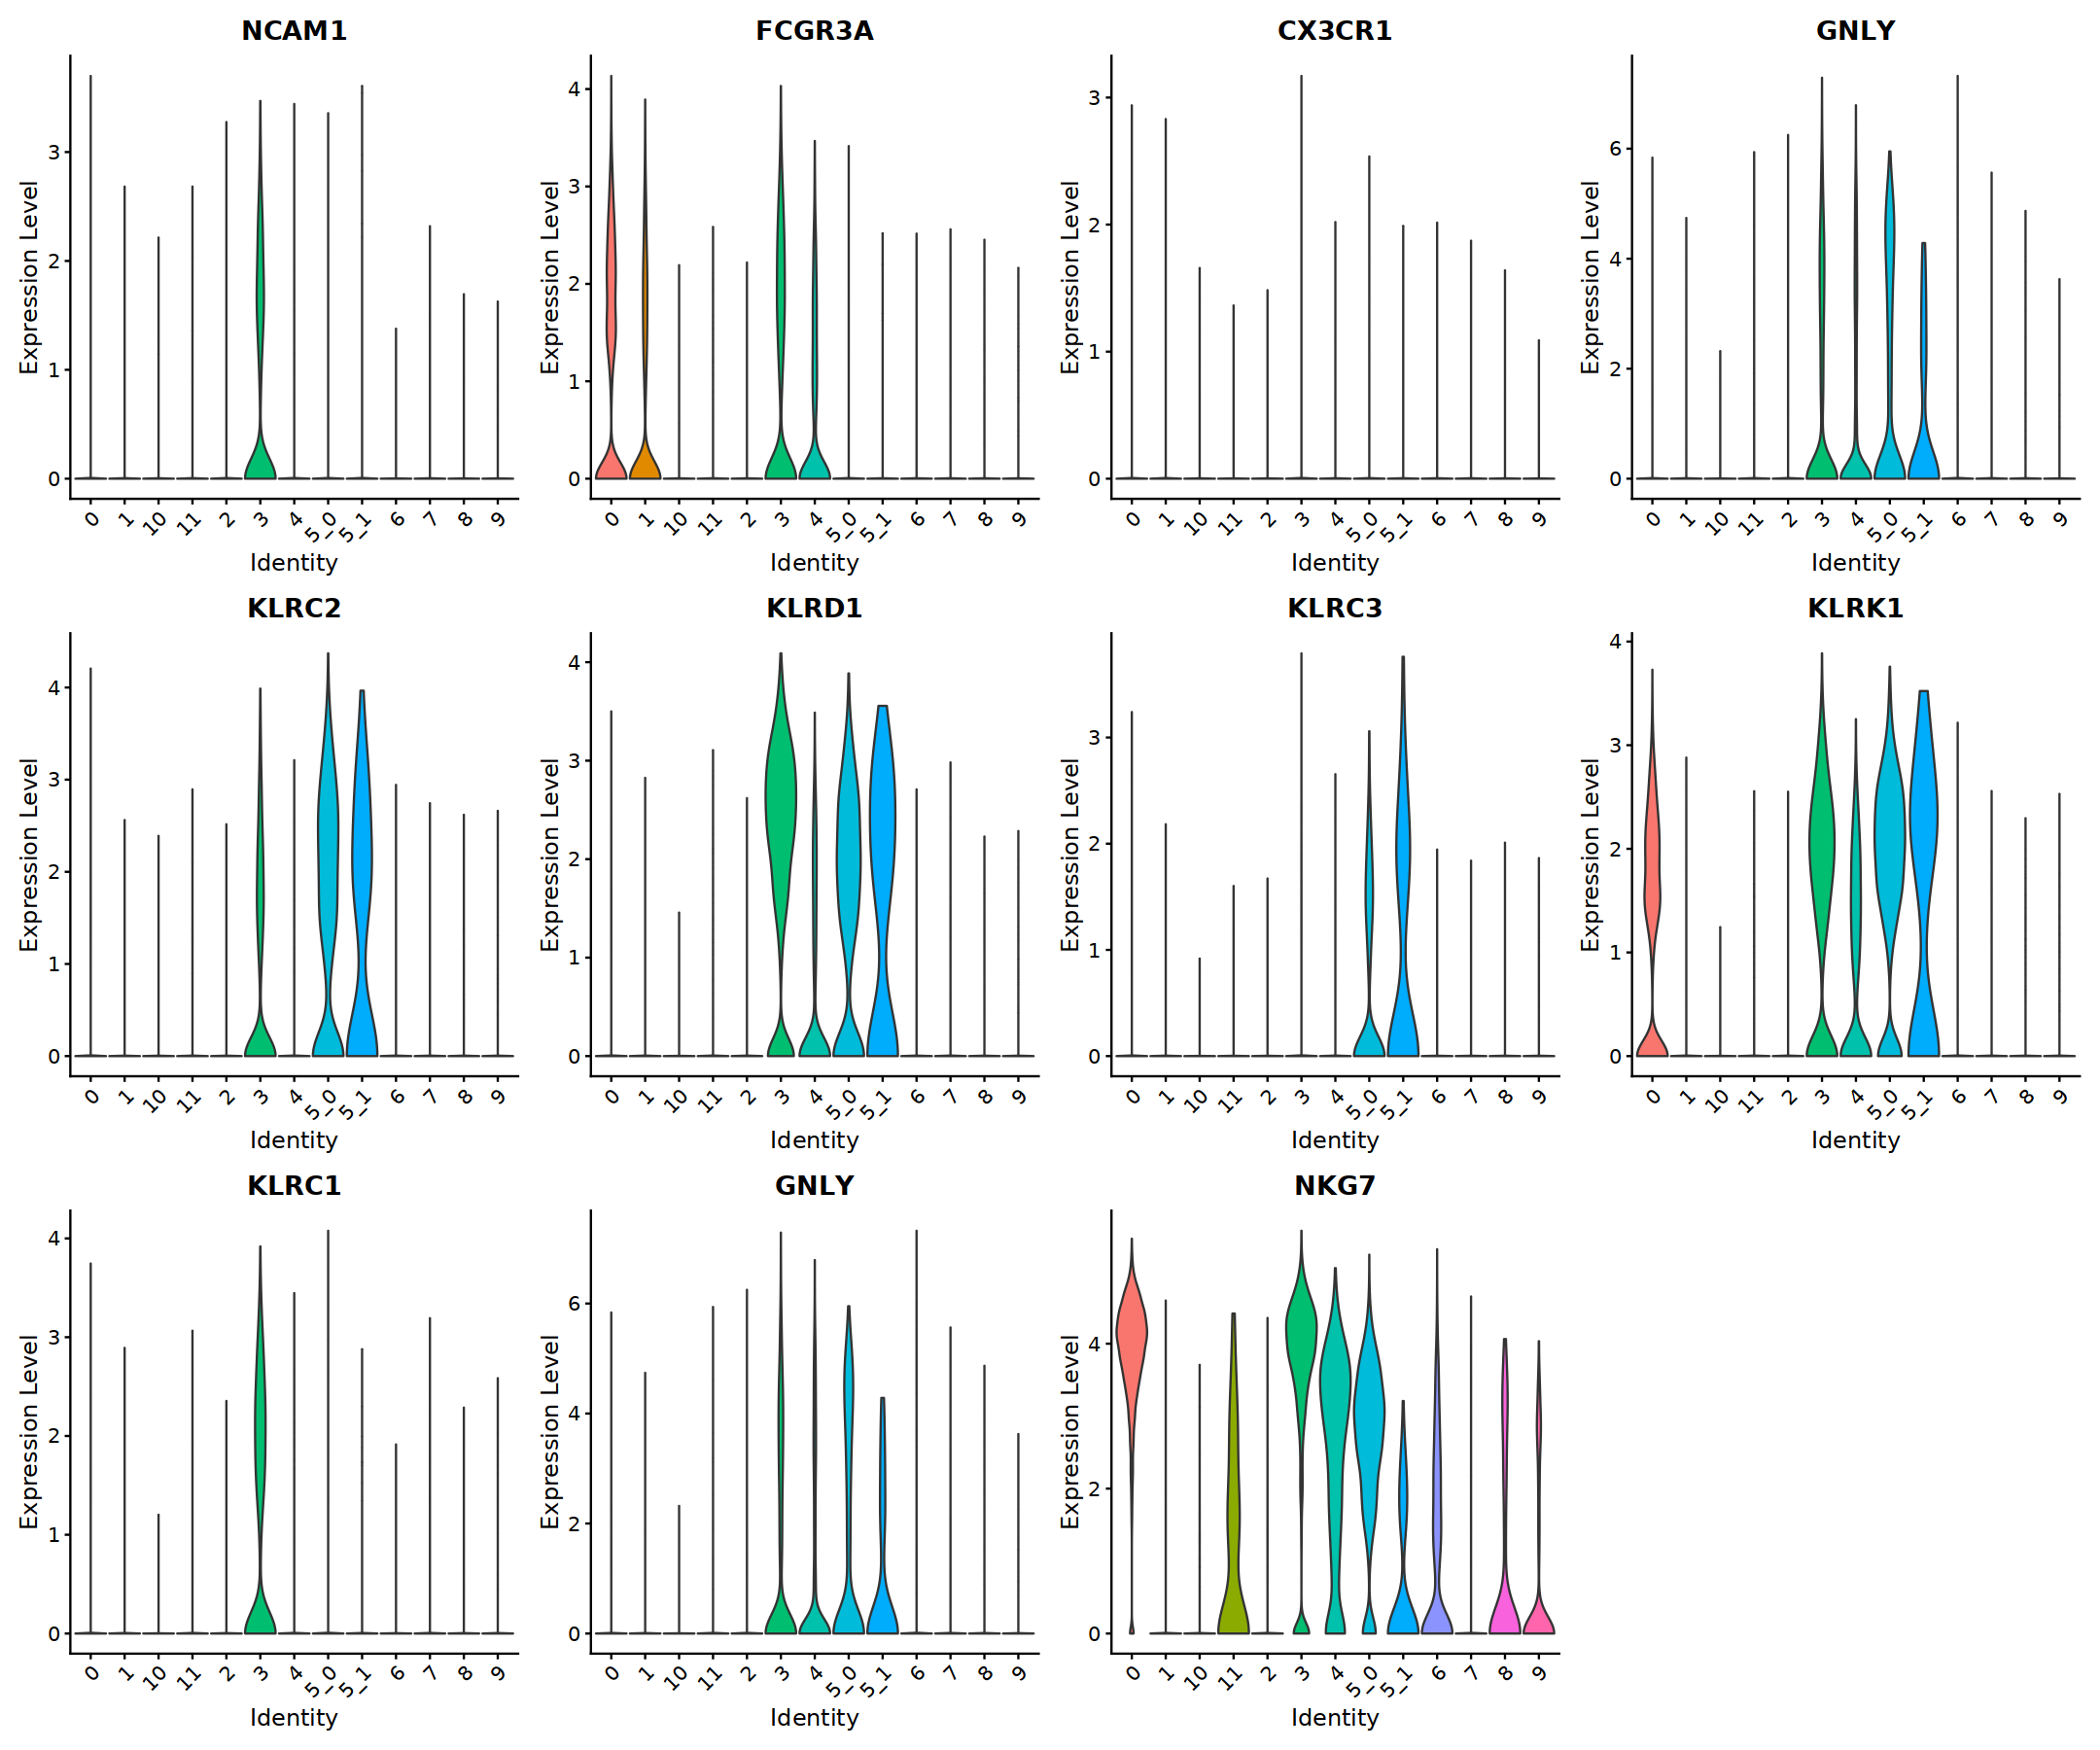

In [39]:
options(repr.plot.width = 18, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, features=markers,ncol=4, 
        pt.size = 0, group.by="subclustering")

#### B-cells

In [40]:
markers = c("CD19","MS4A1","CCR7", "SELL","ITGAX", 
            "CD79A","CD79B","JCHAIN","IGHA1")

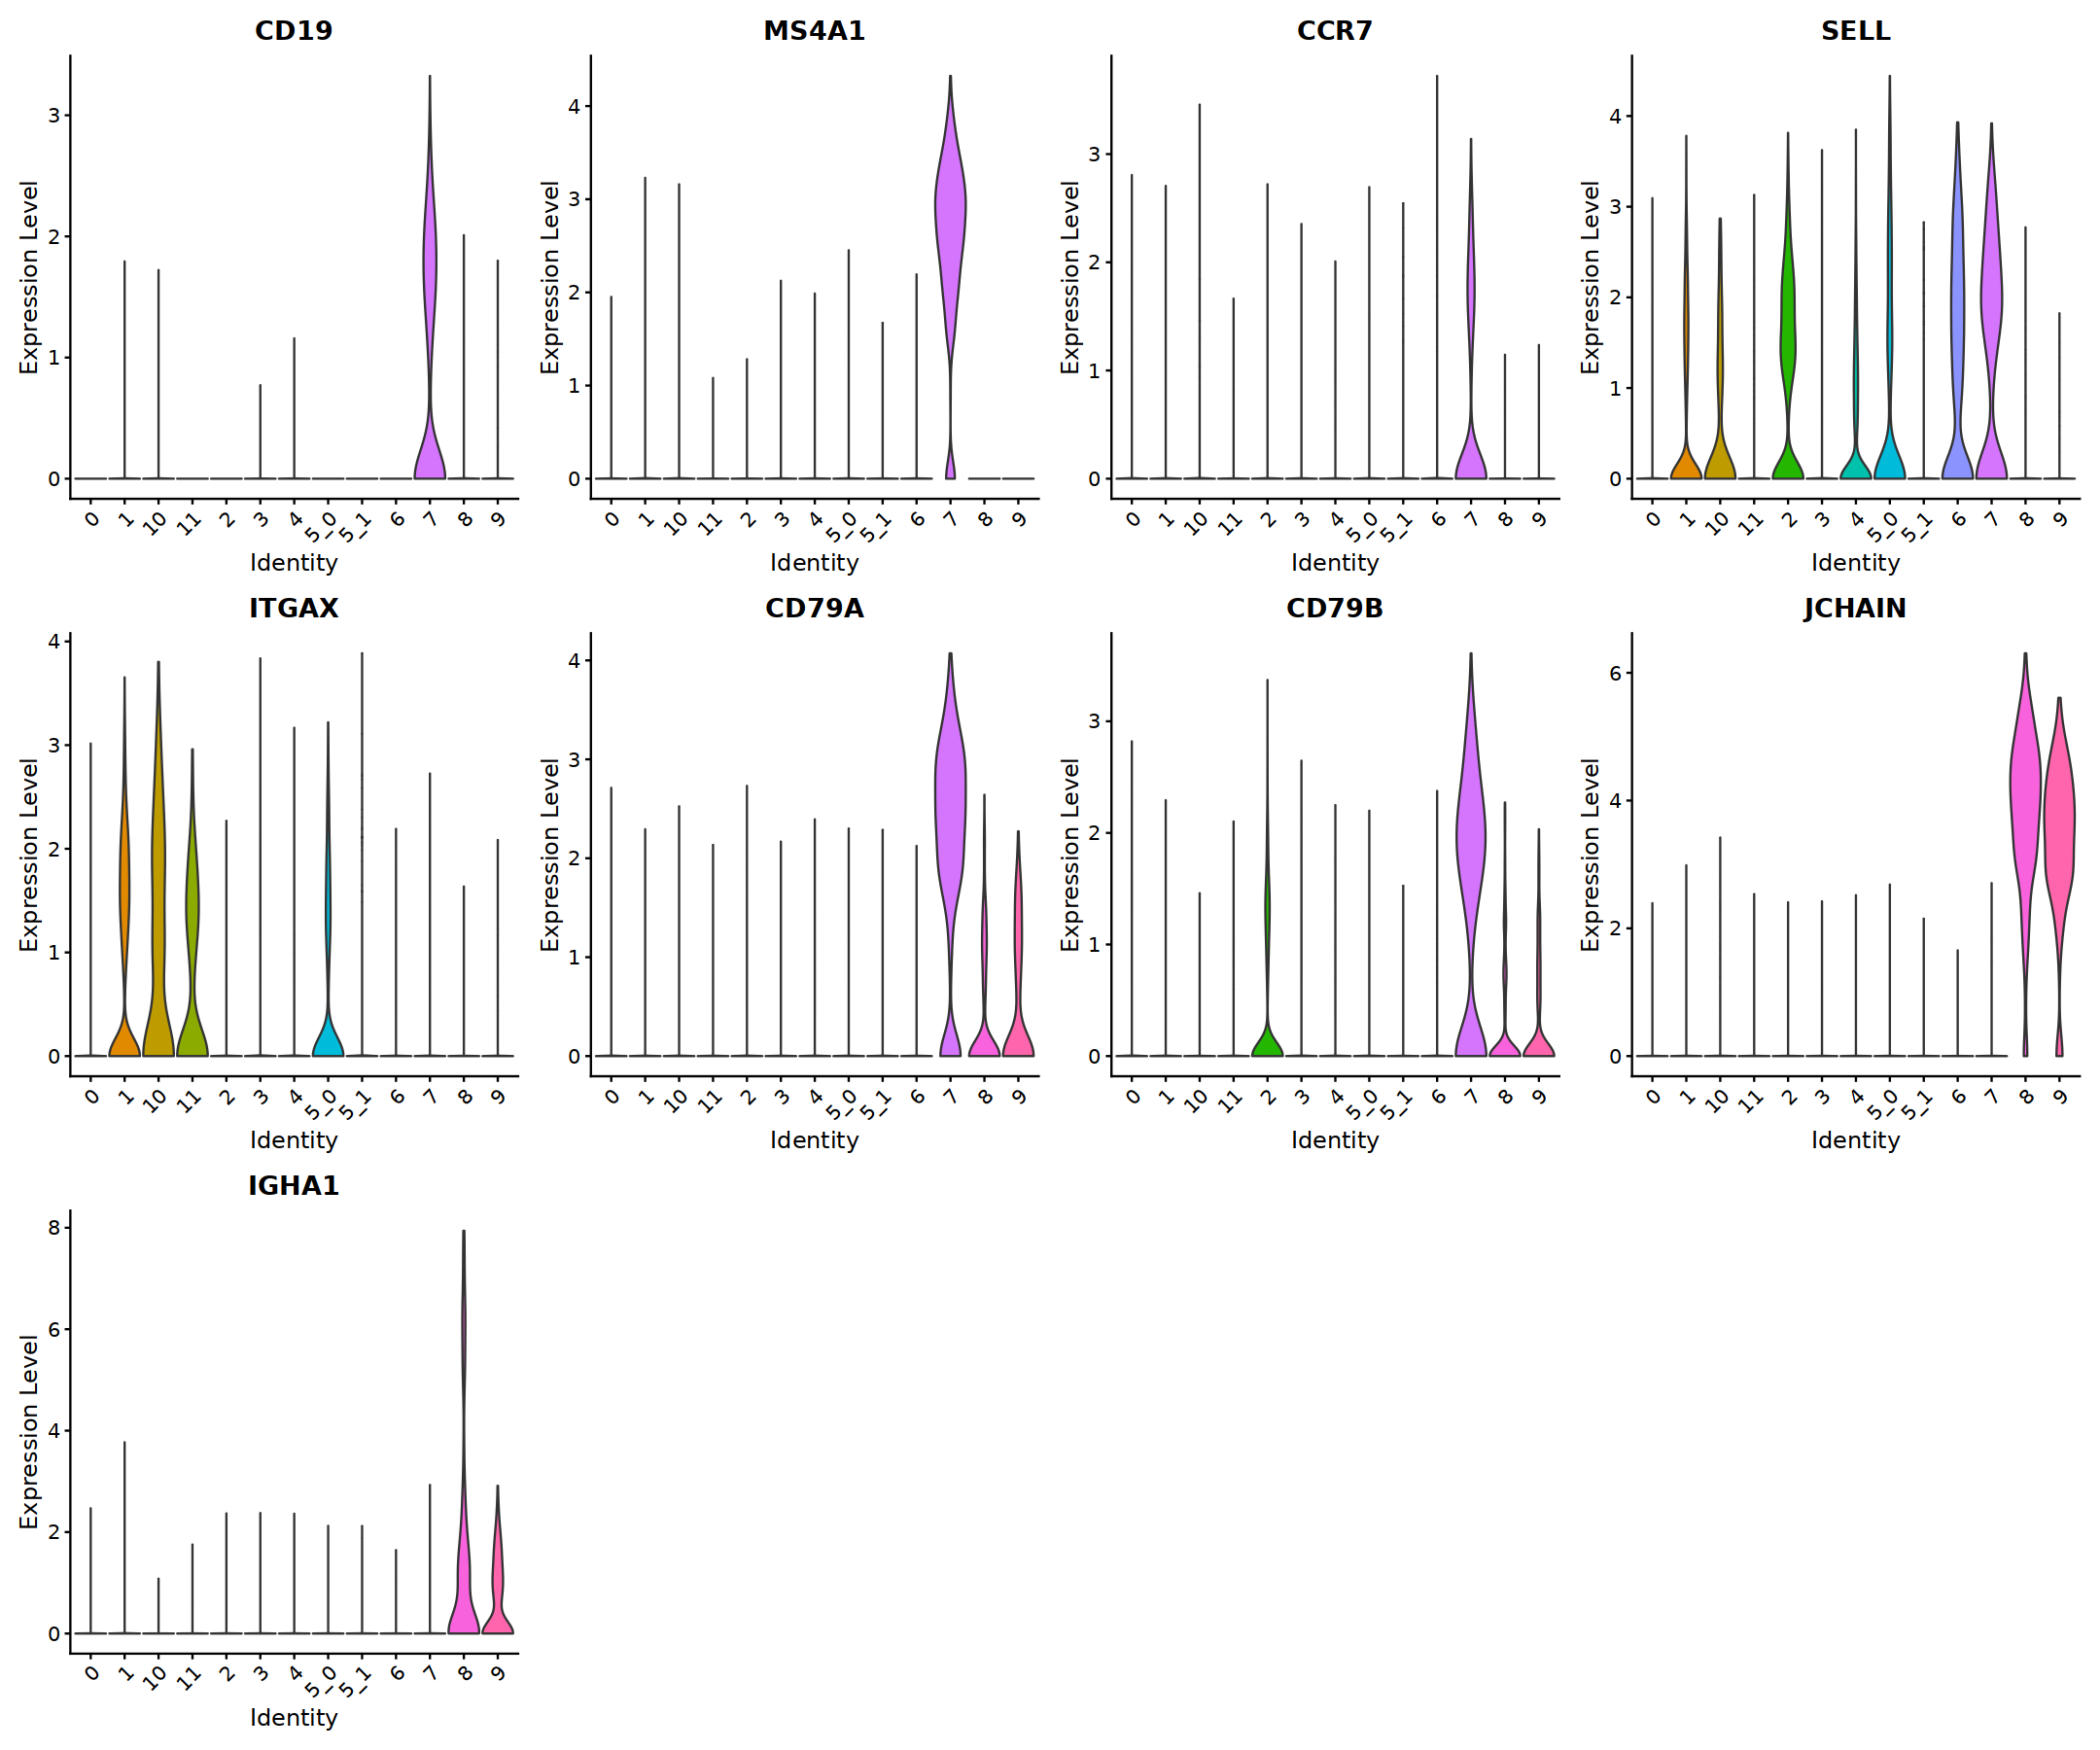

In [41]:
options(repr.plot.width = 18, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, features=markers,ncol=4, 
        pt.size = 0, group.by="subclustering")

#### Monocytes / Macrophages

In [42]:
markers = c("CD68","CD14", "S100A8", "S100A9", "LYZ", 
            "VCAN", "FCN1","FCGR3A", "CX3CR1", "HLA-DRB1", "HLA-DRA")

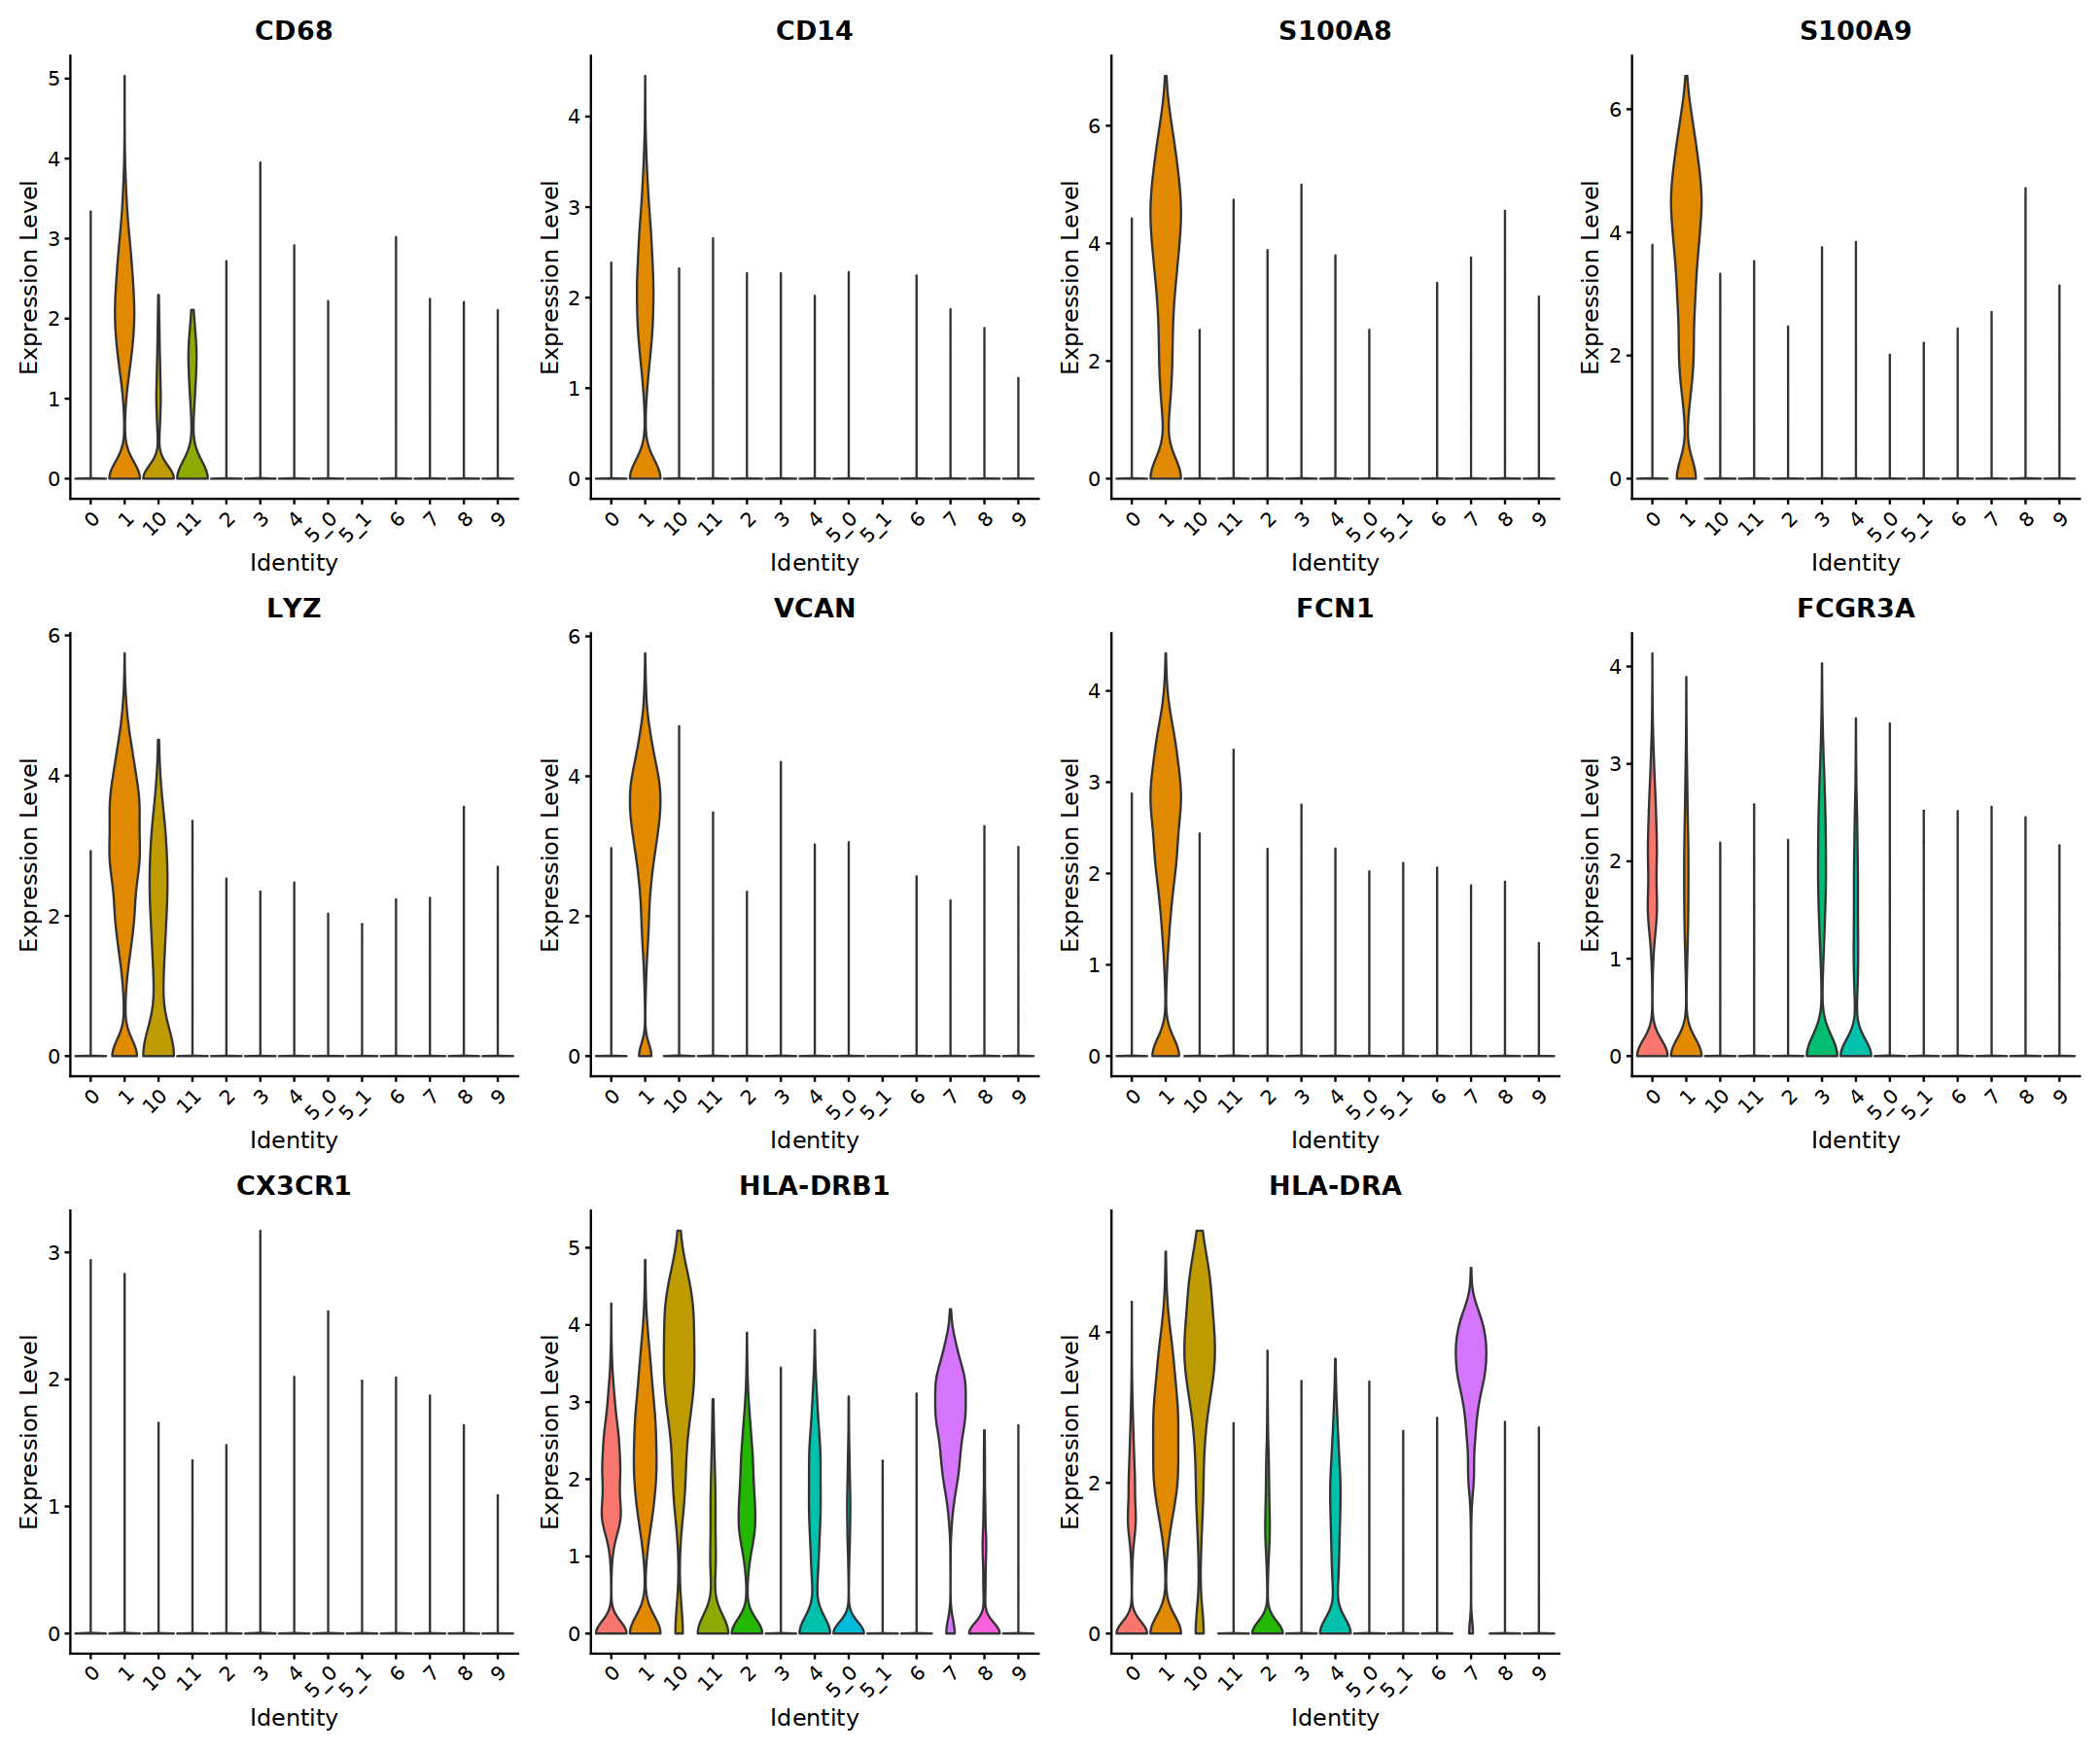

In [43]:
options(repr.plot.width = 18, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, features=markers,ncol=4, 
        pt.size = 0, group.by="subclustering")

#### Dendritic cells

In [44]:
markers = c("CLEC9A", "XCR1", "IDO1","FCER1A", 
            "CLEC10A","ITGAX","SIGLEC6","IL3RA","JCHAIN")

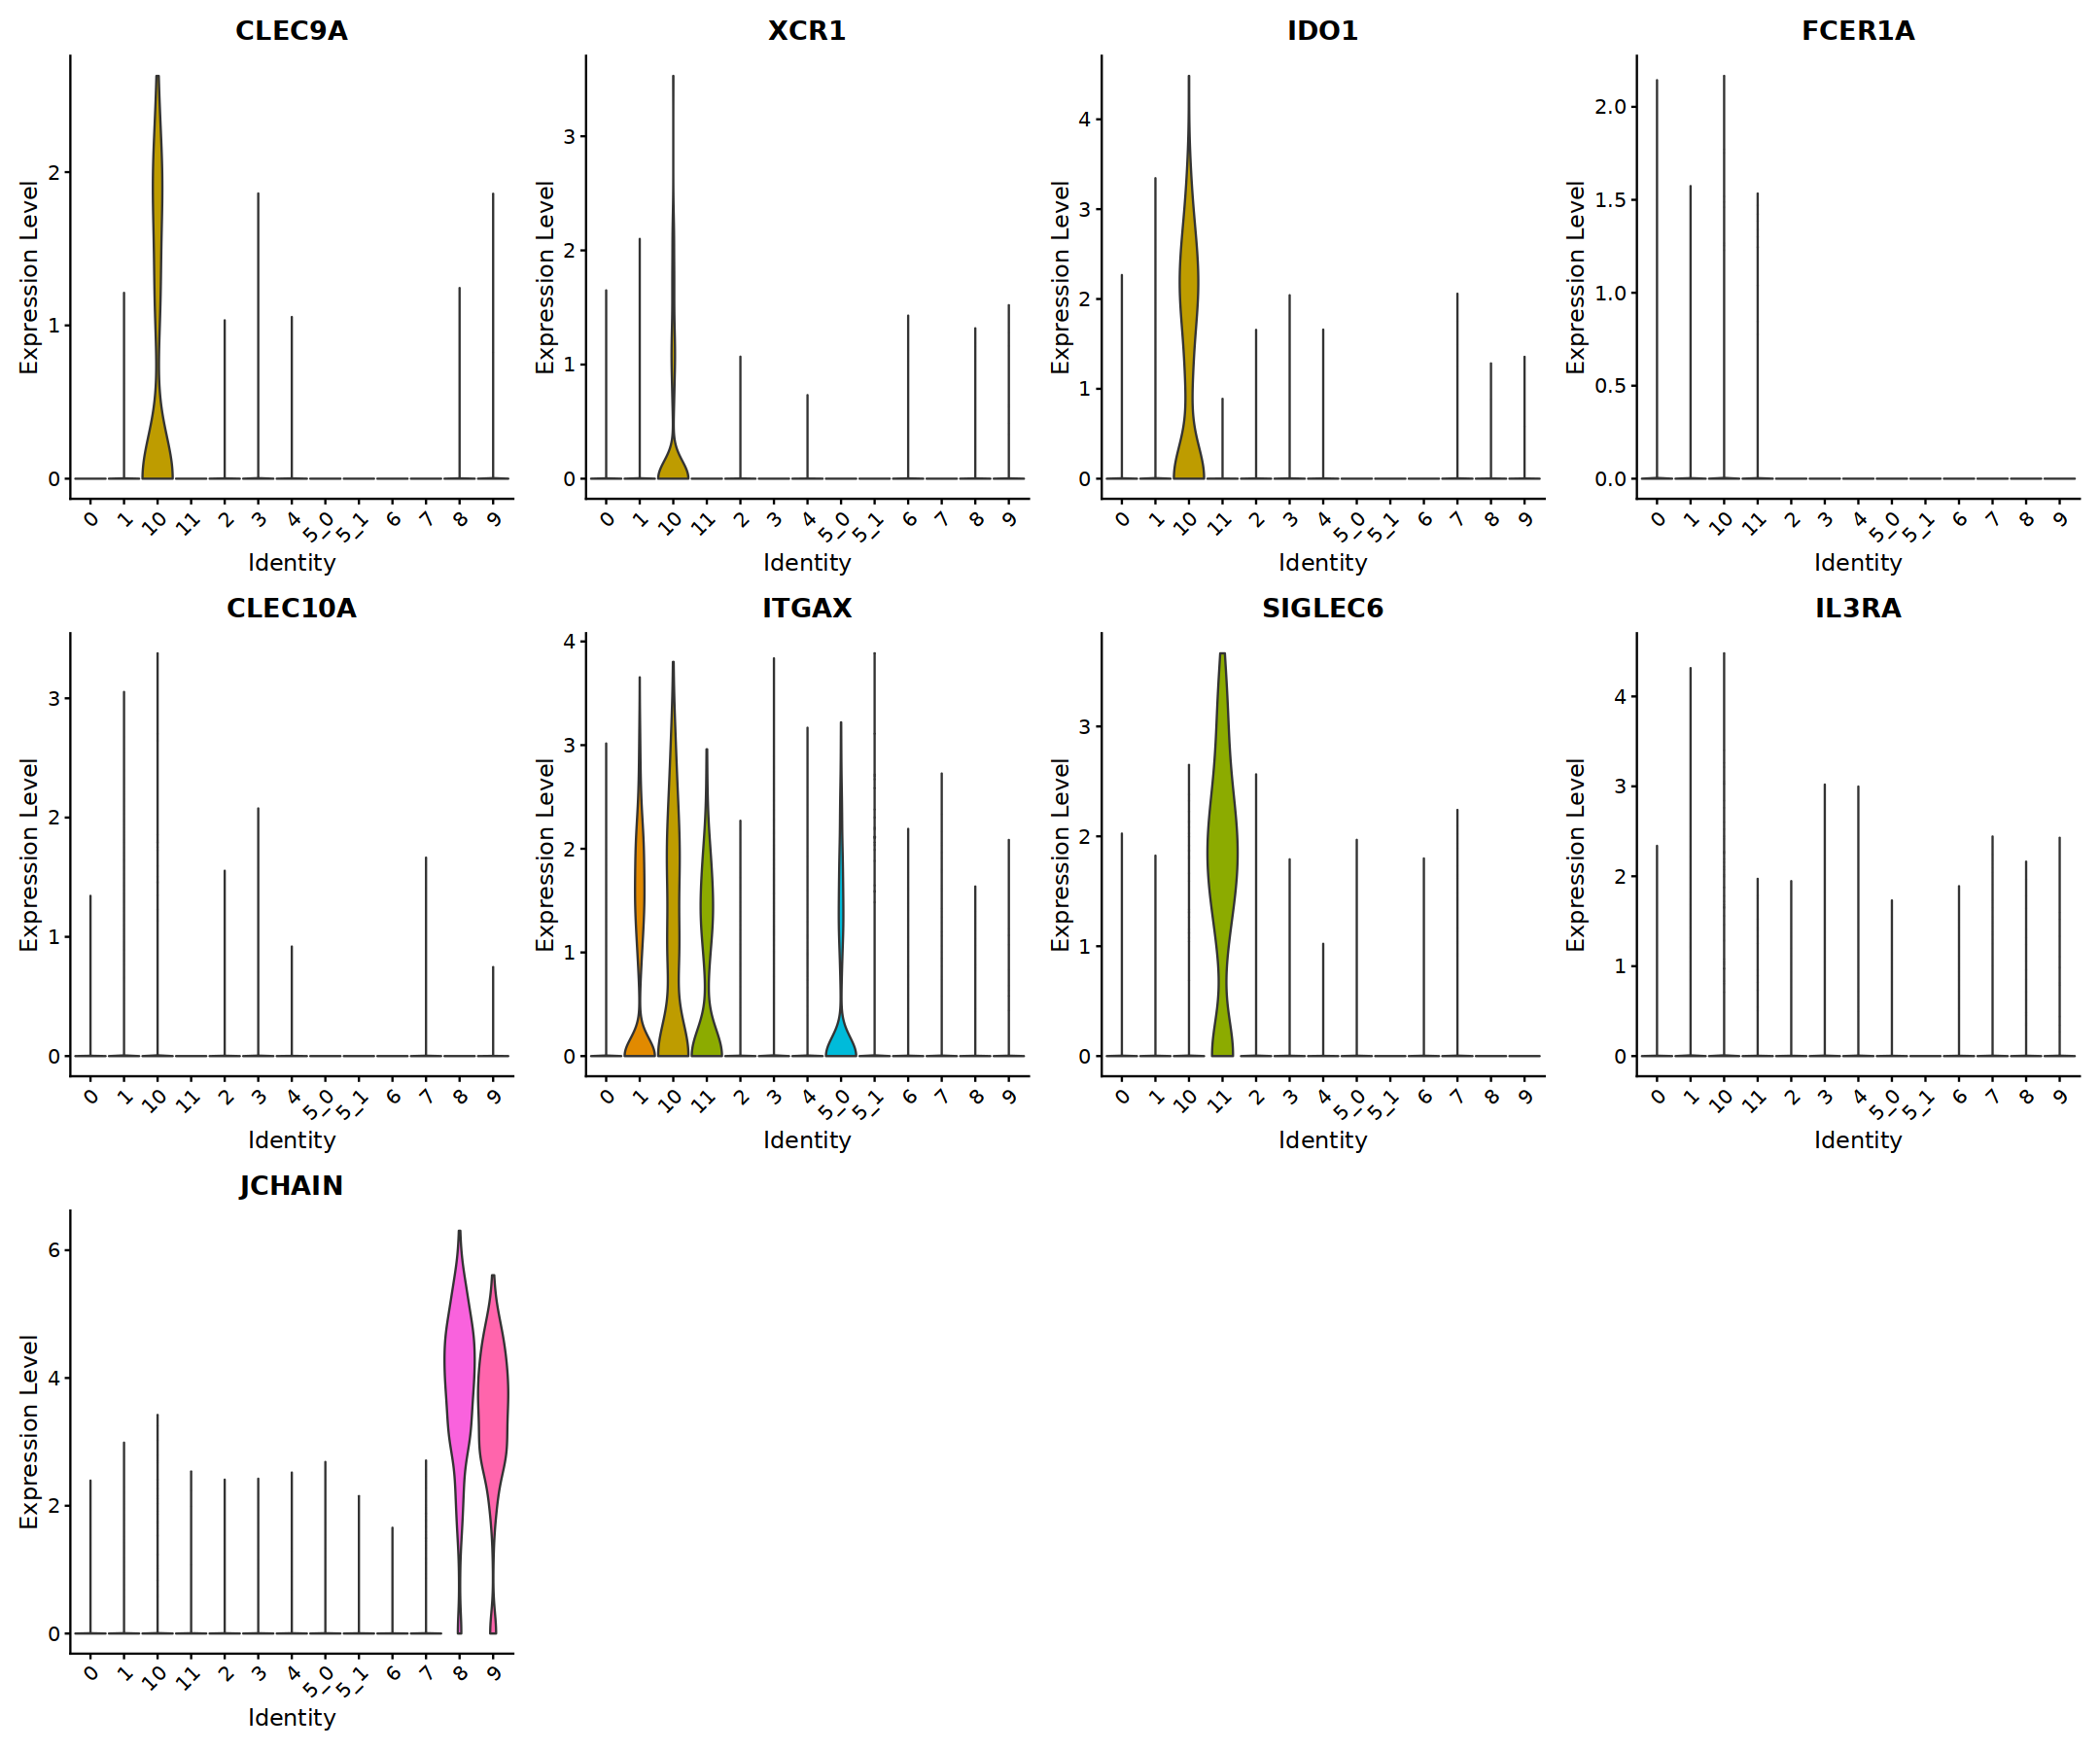

In [45]:
options(repr.plot.width = 18, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, features=markers,ncol=4, 
        pt.size = 0, group.by="subclustering")

Check markers per cluster to ensure annotation downstream 

In [46]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct=0.1, logfc.threshold=0.1, 
                              random.seed=0, max.cells.per.ident=2000, 
                              only.pos=TRUE)

Calculating cluster 5_0

Calculating cluster 0

Calculating cluster 6

Calculating cluster 4

Calculating cluster 2

Calculating cluster 3

Calculating cluster 11

Calculating cluster 5_1

Calculating cluster 1

Calculating cluster 7

Calculating cluster 10

Calculating cluster 8

Calculating cluster 9



In [47]:
rna.markers <- rna.markers %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC))

In [48]:
write_csv(rna.markers, here(glue("{annot}/{robj_dir}/4.0.1-clusters_intgr_all_Tumor.csv")))

## Renaming

In [49]:
rename_clusters= list("0"="CD8 T cells", 
                      "1"="Mφ Monocytes",
                      "2"="CD4 T cells",
                      "3"="NKs",
                      "4"="Proliferative cells",
                      "5_0"="CD8 T cells",
                      "5_1"="γδ T cells",
                      "6"="T helpers",
                      "7"="B cells",
                      "8"="Plasma cells",
                      "9"="Plasma cells",
                      "10"="Dendritic cells",
                      "11"="Mast cells")

seurat_obj <- RenameIdents(object = seurat_obj, rename_clusters)
seurat_obj$l1_annot <- Idents(seurat_obj)

In [50]:
generate_color <- function(names_list) {
  colors <- ifelse(names_list %in% c("T helpers", 
                                     "Proliferative cells","γδ T cells"), "white", "black")
  return(colors)
}

color_labels <- generate_color(unique(Idents(seurat_obj)))

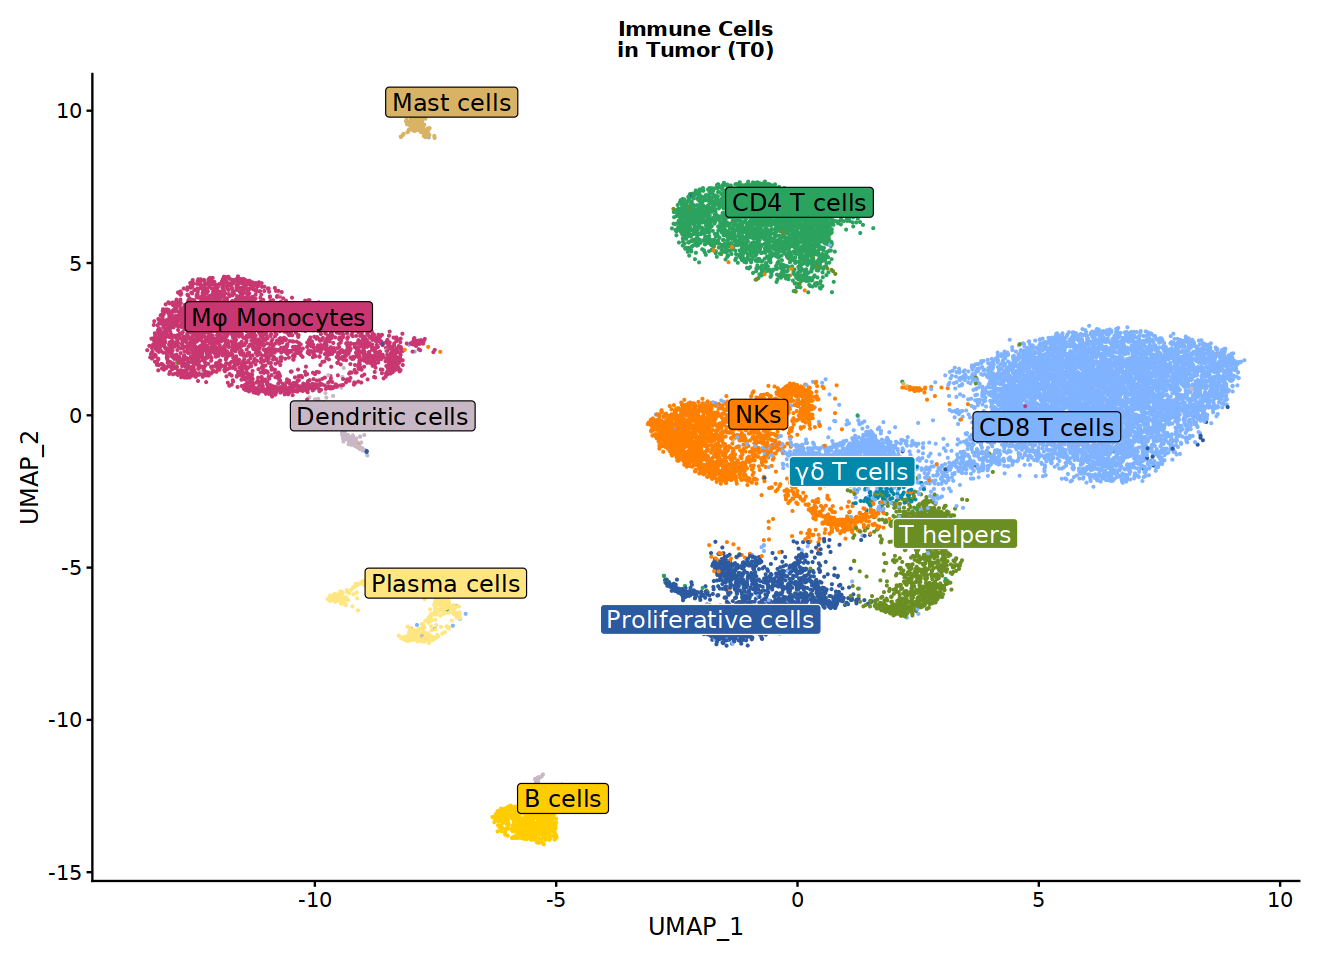

In [51]:
options(repr.plot.width = 11, repr.plot.height = 8, warn=-1,verbose = FALSE)
dpc <- DimPlot(
  seurat_obj,
  reduction = "umap",
  label = T,
  label.box = TRUE,
  label.size = 5,
  label.color = as.list(color_labels),
  repel = TRUE,
  cols = unlist(intgr_pal),
  pt.size = 0.1
) + NoLegend() + ggtitle('Immune Cells\nin Tumor (T0)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))
dpc

In [52]:
Idents(seurat_obj) <- factor(x = Idents(seurat_obj), levels = sort(levels(seurat_obj)))

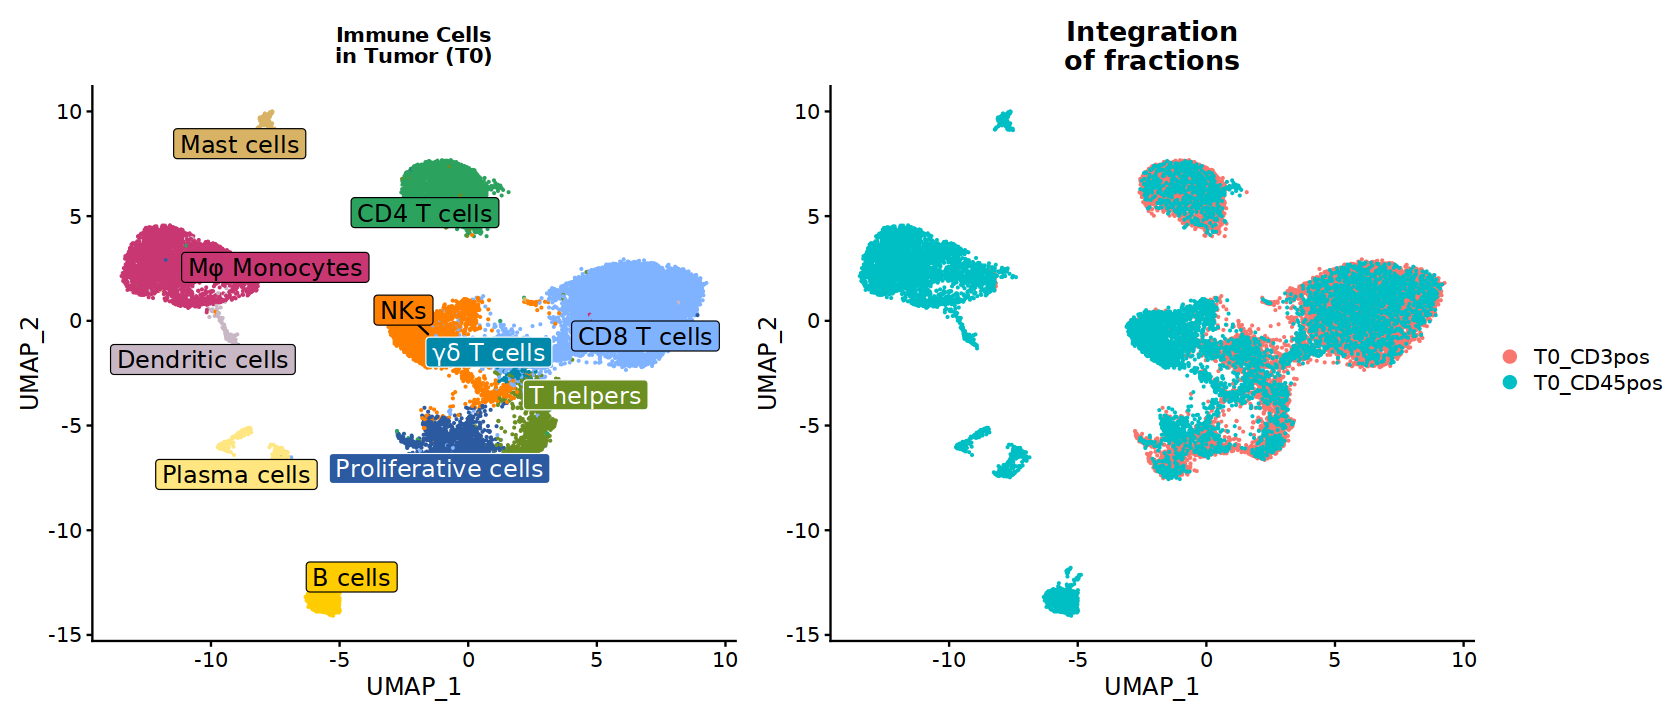

In [53]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
dpc+dpt

In [54]:
custom_order = c("4","2","0", "5_0","6","5_1","3","1","10","7","8", "9","11")

In [55]:
seurat_obj$subclustering <- factor(seurat_obj$subclustering, levels = custom_order)

In [56]:
# selection of top markers
markers = c("MKI67", "TOP2A",
            "CD3E", "CD4","CD8A","CD8B",
            "RORA", "IL21", "CTLA4",
            "TRGV10", "TRDV1",
            "NCAM1", "GNLY", "NKG7",
            "CD68","CD14", "S100A8","FCGR3A",
            "SIGLEC6","CLEC9A","IDO1",
            "CD19","MS4A1",
            "JCHAIN", "IGHM",
            "KIT", "CPA3")

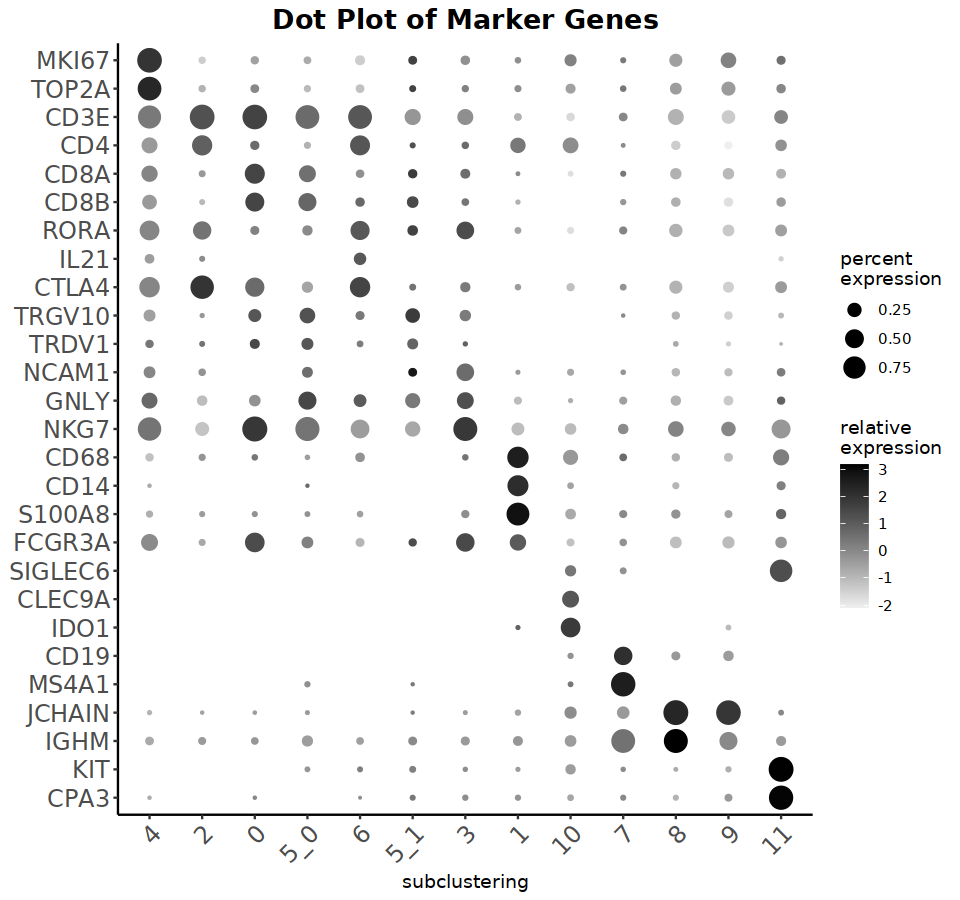

In [57]:
options(repr.plot.width = 8, repr.plot.height = 7.5, warn=-1,verbose = FALSE)
dittoDotPlot(seurat_obj, vars = rev(markers),
    group.by = "subclustering", x.labels.rotate=TRUE, 
    min.color="#f0f0f0", max.color="#000000",
    slot="data", scale = TRUE) + 
    ggtitle(glue('Dot Plot of Marker Genes')) + 
    theme(
        plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        axis.text.x = element_text(size = 14),
        axis.text.y = element_text(size = 14),)+coord_flip()

## Save

In [58]:
# tidy metadata
seurat_obj@meta.data <- seurat_obj@meta.data[,c('orig.ident','nCount_RNA','nFeature_RNA',
                                                'sample_org','timepoint','replicate',
                                                'sample_id','pct_mt','percent.ribo',
                                                'doublet_score','doublet_pred','S.Score',
                                                'G2M.Score','Phase','old.ident','subclustering',
                                                'l1_annot')]

In [59]:
saveRDS(seurat_obj, here(glue("{annot}/{robj_dir}/4.0.1-l1_intgr_all_Tumor.rds")))

In [60]:
ggsave(plot = dpc, width = 11, height = 8, dpi = 300, 
       file = here::here(glue::glue("{annot}/{plt_dir}/4.0.1-umap_immune_T0_intg.png")))

In [61]:
ggsave(plot = cd3_pl, width = 14, height = 4.5, dpi = 300, 
       file = here::here(glue::glue("{annot}/{plt_dir}/4.0.1-umap_frac_T0_intg.svg")))

## Session Info

In [62]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12    dittoSeq_1.6.0     harmony_1.0.3      Rcpp_1.0.10       
 [5] lubridate_1.9.3    forcats_1.0.0      stringr_1.5.0      dplyr_1.1.3       
 [9] purrr_1.0.2        readr_2.1.4        tidyr_1.3.0        tibble_3.2.1      
[13] ggplot2_3.4.4      tidyverse_2.0.